# Results
In this notebook we are going to show our analysis done on RateBeer, BeerAdvocate and MatchedBeers datasets. <br><br>
Others important notebooks are in:
- `data/processing/`: here we have all the code needed to process the data and make them into a format suitable for our purposes.
- `data/cleaning`: here we have all the code needed for the very preliminary analysis, data cleaning and data filling. 

The data are firstly processed with the code in the `data/processing/` folder and then cleaned with the code in the `data/cleaning/` folder. Finally, the cleaned data are used in this notebook for the analysis.


## Preliminary analysis
In this notebook we mostly focused on general analysis of the data. We mostly focused on performing temporal and spatial analysis of the data, ensured that all the needed data were available and finally that the data were consistent and we'll show the results that we obtained. <br><br>
We plan to do a more in-depth analysis in the next milestone, where we will focus on in-depth analysis of the data.

### Import all the required libraries

In [ ]:
import polars as pl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import geopandas as gpd
import numpy as np
import tqdm
import os
from src.utils.data_desc import *
from src.utils.matched_dataset import *

### RateBeer
#### Data loading

In [2]:
df_beers = pl.read_parquet("./data/RateBeer/processed/beers.pq")
df_breweries = pl.read_parquet("./data/RateBeer/processed/breweries.pq")
df_users = pl.read_parquet("./data/RateBeer/processed/users.pq")
df_ratings_no_text = pl.read_parquet("./data/RateBeer/processed/ratings_no_text.pq")

#### Data analysis

Now we can take a look at what our data looks like visually. Taking a look at data can often reveal hidden patterns or distributions that are not easily visible while just looking at the numbers.

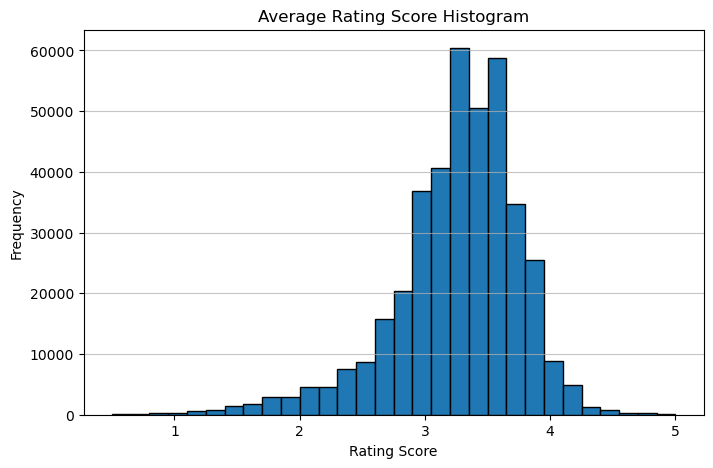

In [3]:
# Convert the 'rating_score_avg' column to a list for plotting
rating_score_avg = df_beers.select(pl.col("rating_score_avg").filter(pl.col("rating_score_avg").is_not_null())).to_series().to_list()

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(rating_score_avg, bins=30, edgecolor='black')
plt.title('Average Rating Score Histogram')
plt.xlabel('Rating Score')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

Here we see that the rating_score_avg seems to resemble a normal distribution. 

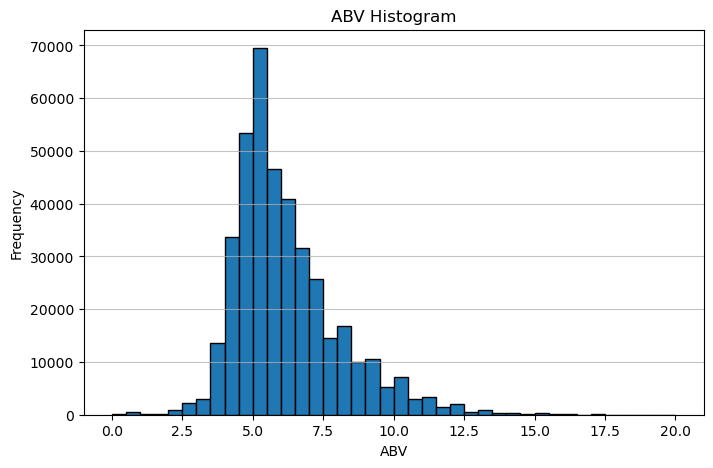

In [4]:
# Sample data selection
abv = df_beers.select(pl.col("abv").filter(pl.col("abv").is_not_null())).to_series().to_list()

# Plot histogram with more bins between 0 and 10
plt.figure(figsize=(8, 5))
plt.hist(abv, bins=40, range=(0, 20), edgecolor='black')  # Increase number of bins for better resolution
plt.title('ABV Histogram')
plt.xlabel('ABV')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()


Just like in the BeerAdvocate dataset, the ABV seems at first sight to follow a right-skewed distribution. There are very few beers with less than 4% alcohol.

The following three plots are for the number of beers per brewery, the number of reviews per beer and the number of reviews per user. All three of them show a lot of entries in the beginning, and a few entries with very large numbers. This seems to suggest a power law. We can investigate this.

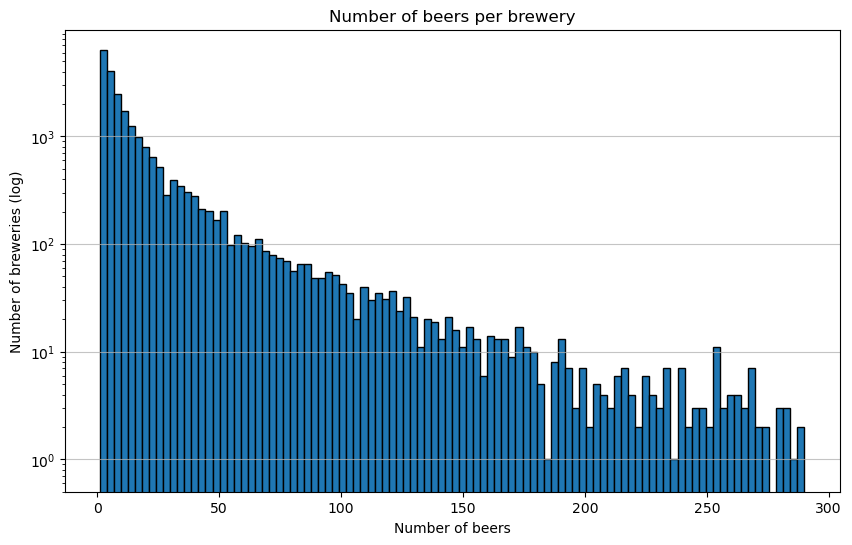

In [5]:
# Plot an histogram with the number of beers per brewery
values = df_breweries['beers_count'].value_counts()

# Display the plot
fig, ax = plt.subplots(figsize=(10, 6))
plt.hist(values["beers_count"], bins=100, weights=values["count"], edgecolor='black')
plt.yscale('log')
plt.xlabel('Number of beers')
plt.ylabel('Number of breweries (log)')
plt.title('Number of beers per brewery')
plt.grid(axis='y', alpha=0.75)
plt.ylim(bottom=0.5)
plt.show()

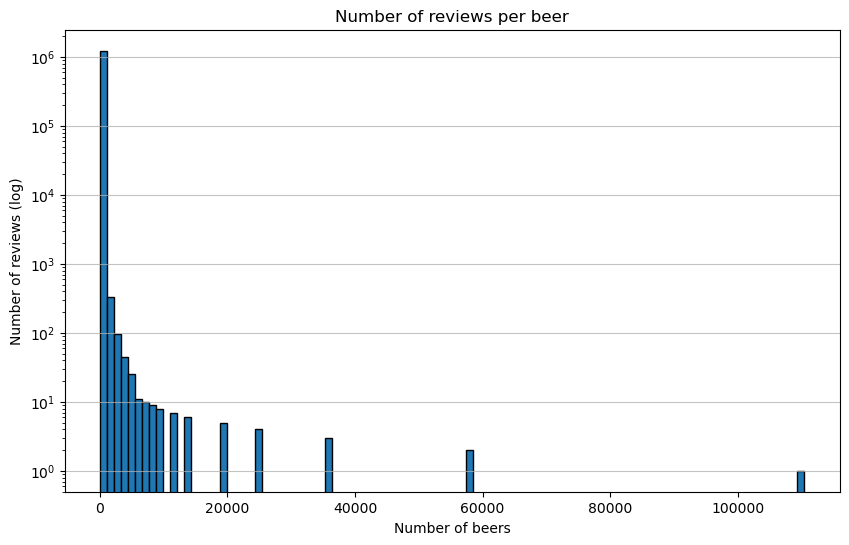

In [6]:
# Plot an histogram with the number of reviews for each beer
values = df_beers['nbr_ratings'].value_counts()

# Display the plot
fig, ax = plt.subplots(figsize=(10, 6))
plt.hist(values["count"], bins=100, weights=values["nbr_ratings"], edgecolor='black')
plt.yscale('log')
plt.ylabel('Number of reviews (log)')
plt.xlabel('Number of beers')
plt.title('Number of reviews per beer')
plt.grid(axis='y', alpha=0.75)
plt.ylim(bottom=0.5)
plt.show()

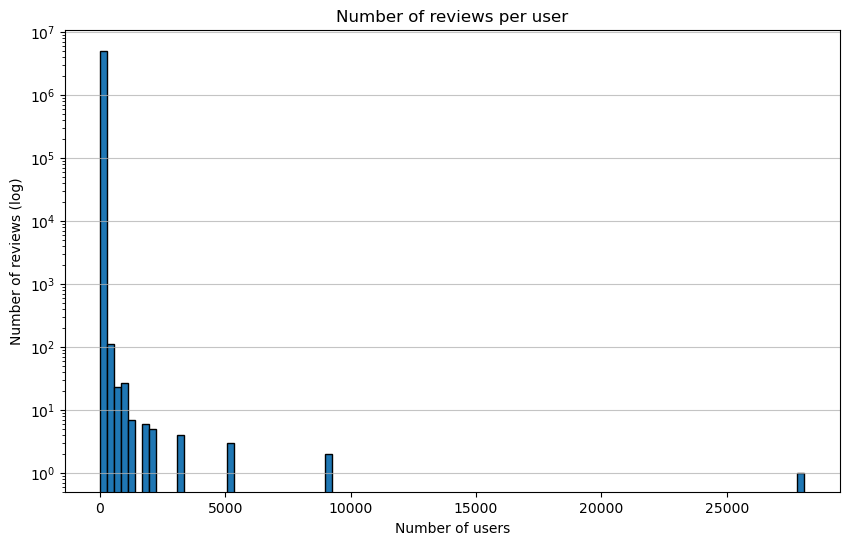

In [7]:
# Plot an histogram with the number of reviews for each user
values = df_users['number_of_ratings'].value_counts()

# Display the plot
fig, ax = plt.subplots(figsize=(10, 6))
plt.hist(values["count"], bins=100, weights=values["number_of_ratings"], edgecolor='black')
plt.yscale('log')
plt.ylabel('Number of reviews (log)')
plt.xlabel('Number of users')
plt.title('Number of reviews per user')
plt.grid(axis='y', alpha=0.75)
plt.ylim(bottom=0.5)
plt.show()

To verify if we are actually dealing with power laws, we can plot the plots again, but now as a probability density function on a log-log scale.

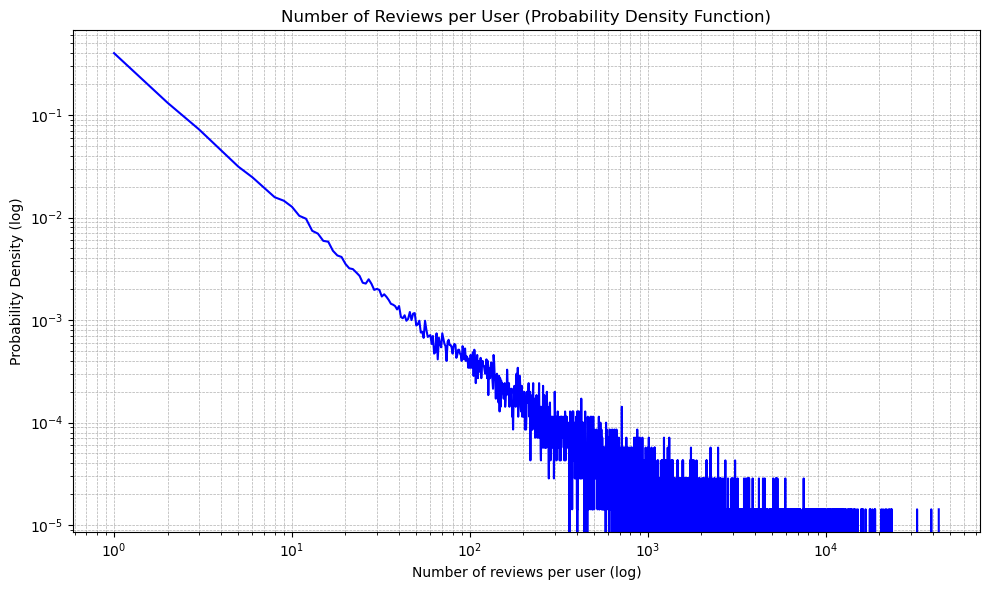

In [8]:
values = df_users['number_of_ratings'].value_counts().to_pandas()

all_ratings = np.arange(values['number_of_ratings'].min(), values['number_of_ratings'].max() + 1)
values = values.set_index('number_of_ratings').reindex(all_ratings)
values = values.fillna(0)  # Fill missing counts with 0

# Calculate PDF as normalized counts
pdf = values['count'] / values['count'].sum()

# Plotting the PDF
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(values.index, pdf, color='blue')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Number of reviews per user (log)')
ax.set_ylabel('Probability Density (log)')
ax.set_title('Number of Reviews per User (Probability Density Function)')
ax.grid(True, which="both", ls="--", linewidth=0.5)

plt.tight_layout()
plt.show()

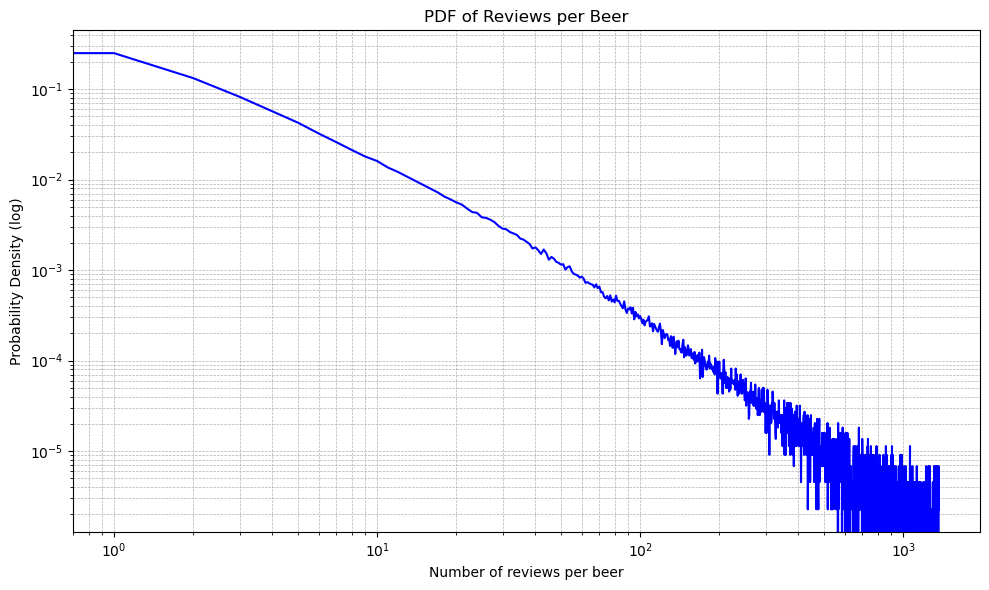

In [9]:
values = df_beers['nbr_ratings'].value_counts().to_pandas()

all_ratings = np.arange(values.index.min(), values.index.max() + 1)
values = values.set_index('nbr_ratings').reindex(all_ratings)
values = values.fillna(0)  # Fill missing counts with 0

# Calculate PDF as normalized counts
pdf = values['count'] / values['count'].sum()

# Plotting the PDF
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(values.index, pdf, color='blue')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Number of reviews per beer')
ax.set_ylabel('Probability Density (log)')
ax.set_title('PDF of Reviews per Beer')
ax.grid(True, which="both", ls="--", linewidth=0.5)

plt.tight_layout()
plt.show()

Here, just like in the BeerAdvocate dataset, these are fairly straight lines, so we are dealing with power laws. This has the same implications as described in that notebook.

But also here we can see that the amount of beers per brewery does not follow a power law.

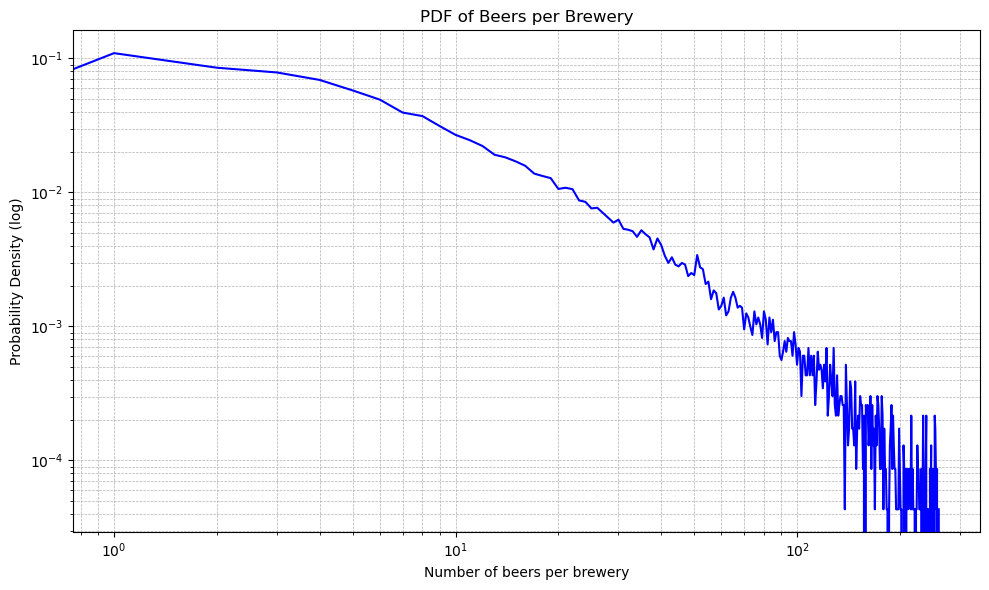

In [10]:
values = df_breweries['beers_count'].value_counts().to_pandas()

all_ratings = np.arange(values.index.min(), values.index.max() + 1)
values = values.set_index('beers_count').reindex(all_ratings)
values = values.fillna(0)  # Fill missing counts with 0

# Calculate PDF as normalized counts
pdf = values['count'] / values['count'].sum()

# Plotting the PDF
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(values.index, pdf, color='blue')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Number of beers per brewery')
ax.set_ylabel('Probability Density (log)')
ax.set_title('PDF of Beers per Brewery')
ax.grid(True, which="both", ls="--", linewidth=0.5)

plt.tight_layout()
plt.show()

We can now do some initial exploration into potential correlations in our dataframe.

In [11]:
df_beers_corr = df_beers.select([
    'abv', 
    'rating_score_avg', 
    'nbr_interactions', 
])

In [12]:
correlation_matrix = df_beers_corr.to_pandas().dropna().corr()

In [13]:
correlation_matrix

,abv,rating_score_avg,nbr_interactions
abv,1.000000,0.364346,0.049709
rating_score_avg,0.364346,1.000000,0.016294
nbr_interactions,0.049709,0.016294,1.000000


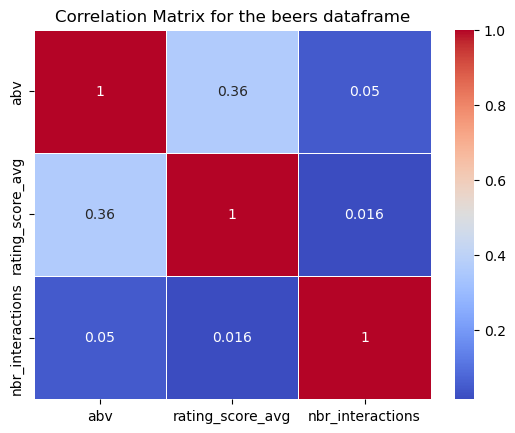

In [14]:
# plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix for the beers dataframe')
plt.show()

Here, just as with BeerAdvocate, we have a similar correlation between ABV and the average rating. This is defined as a weak correlation, but it is still definitely important. This is likely because users of the platform are experienced drinkers and prefer heavier beers. 

#### Geographical analysis

##### User locations by country

As can be seen in the graph below, the largest continent in terms of user base is by far the North America.

Europe comes in second, and South America, Asia and Australia also have sizable audiences. 

Africa and Antarctica both have very few users. The Middle-East is also very devoid of any users. This makes sense, as many countries here have laws that ban the production and consumption of alcohol. 

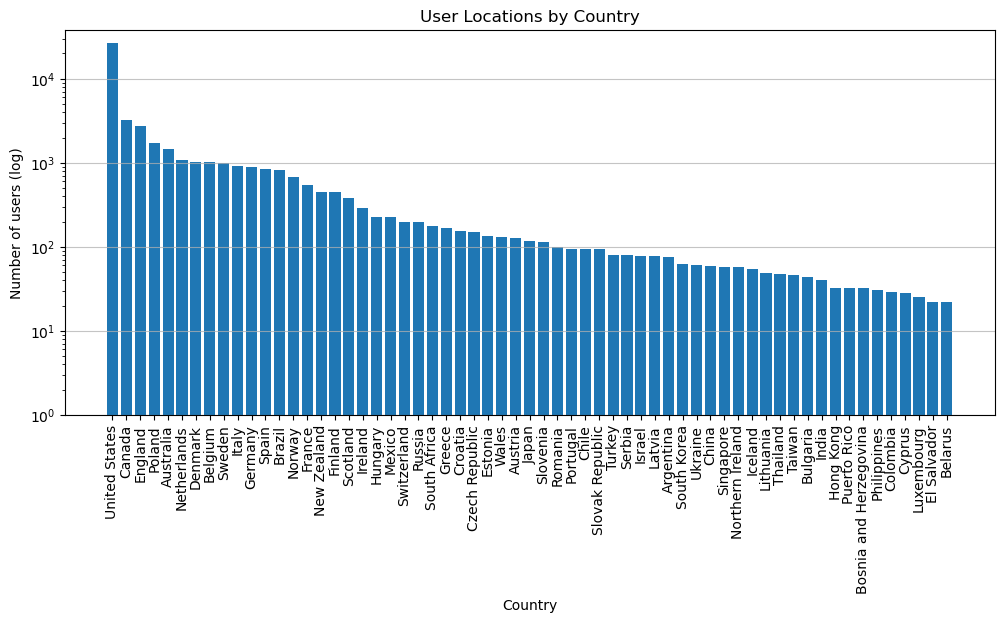

In [15]:
# Convert the polaris datastructure into a pandas dataframe
df_users_pd = df_users.to_pandas()

# Extract country names (split by ', ' and take the last part)
df_users_pd['country'] = df_users_pd['location'].dropna().apply(lambda x: x.split(', ')[0])

# Count occurrences of each country and filter out countries with less than 20 occurrences
country_counts = df_users_pd['country'].value_counts().reset_index()
country_counts_filtered = country_counts[country_counts['count'] >= 20]

# Plot the countries
plt.figure(figsize=(12, 5))
plt.bar(country_counts_filtered['country'], country_counts_filtered['count'])
plt.xticks(rotation=90)
plt.xlabel('Country')
plt.ylabel('Number of users (log)')
plt.yscale('log')
plt.title('User Locations by Country')
plt.grid(axis='y', alpha=0.75)
plt.ylim(bottom=1)
plt.show()

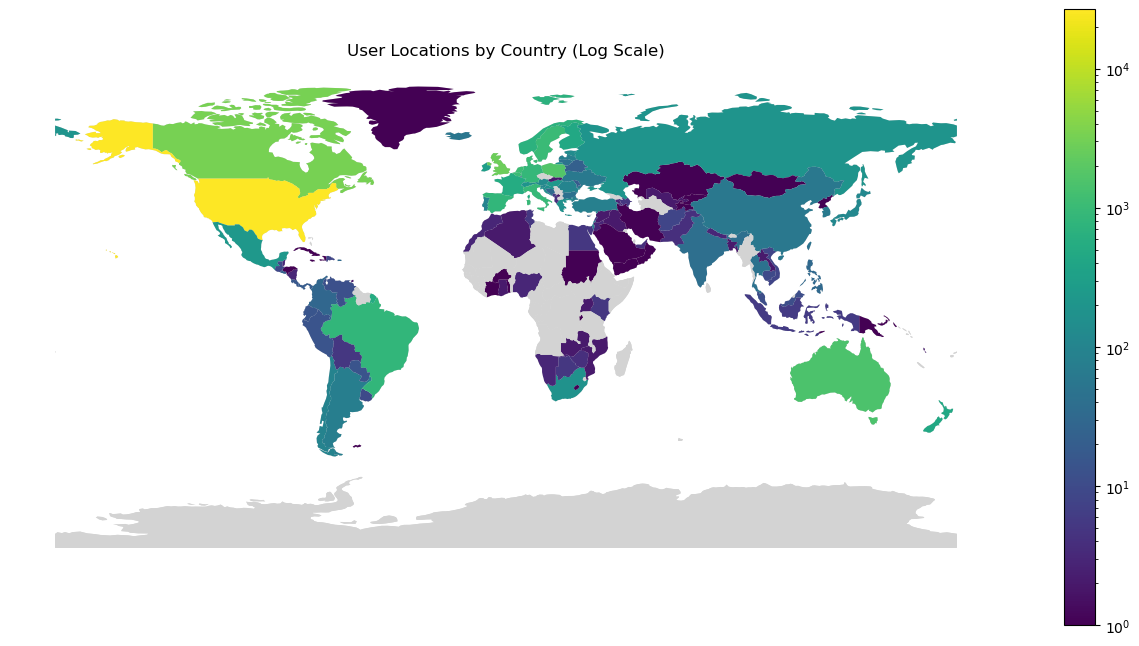

In [16]:
# Do some renaming of country names to match the map dataset
country_counts.loc[country_counts['country'] == 'United States', 'country'] = 'United States of America'
country_counts.loc[country_counts['country'] == 'England', 'country'] = 'United Kingdom'

# Plot on a map the data
world = gpd.read_file("https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip").rename(columns={'ADMIN': 'name'})
merged = world.merge(country_counts, how='left', left_on='name', right_on='country')

# Create figure
fig, ax = plt.subplots(figsize=(16, 8))
world.plot(ax=ax, color='lightgray')  

# Plot with log scale normalization
merged.plot(
    column='count',
    ax=ax,
    legend=True,
    cmap='viridis',  
    norm=mcolors.LogNorm(vmin=1, vmax=merged['count'].max()), 
    missing_kwds={"color": "lightgray"}
)
ax.set_title('User Locations by Country (Log Scale)')
plt.axis('off')
plt.show()

##### Brewery locations by country

In the following two graphs we can see geographical location of breweries. This seems to be quite similar to the location of the users, but a bit flatter. This is likely because users will upload beers they have tried while traveling, and there is a ceiling to how many breweries you can enter into the database, as there are only so many breweries in a given country. 

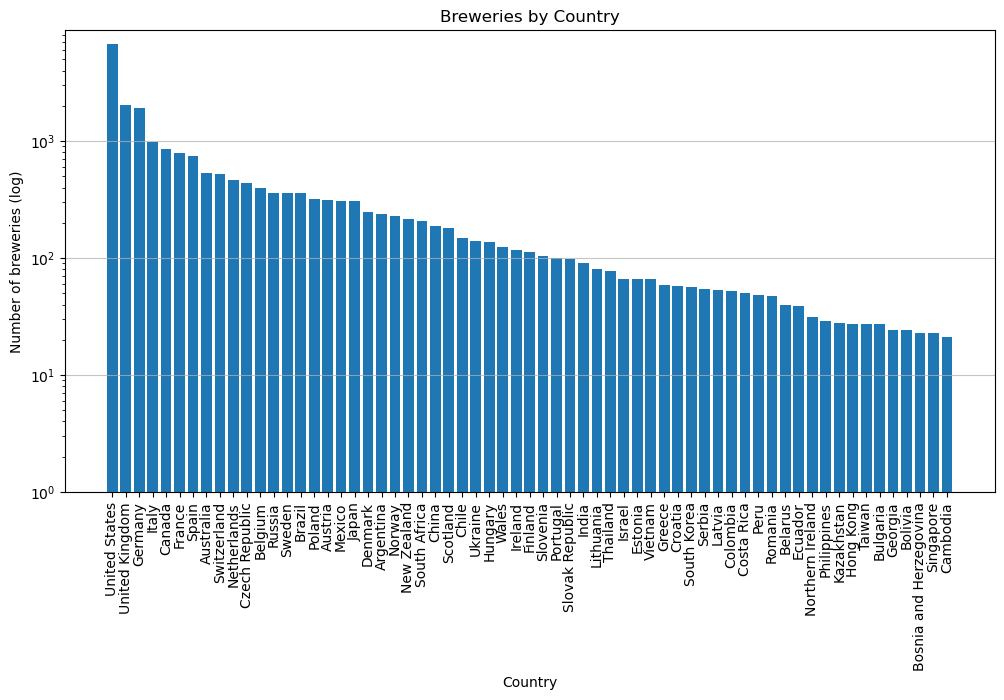

In [17]:
# Convert the polaris datastructure into a pandas dataframe
df_breweries_pd = df_breweries.to_pandas()
df_breweries_pd.loc[df_breweries_pd['location'] == 'England', 'location'] = 'United Kingdom'

# Extract country names (split by ', ' and take the last part)
df_breweries_pd['country'] = df_breweries_pd['location'].dropna().apply(lambda x: x.split(', ')[0])

# Count occurrences of each country and filter out countries with less than 20 occurrences
breweries_country_counts = df_breweries_pd['country'].value_counts().reset_index()
breweries_counts_filtered = breweries_country_counts[breweries_country_counts['count'] >= 20]

# Plot the countries
plt.figure(figsize=(12, 6))
plt.bar(breweries_counts_filtered['country'], breweries_counts_filtered['count'])
plt.xticks(rotation=90)
plt.xlabel('Country')
plt.yscale('log')
plt.ylabel('Number of breweries (log)')
plt.title('Breweries by Country')
plt.grid(axis='y', alpha=0.75)
plt.ylim(bottom=1)
plt.show()

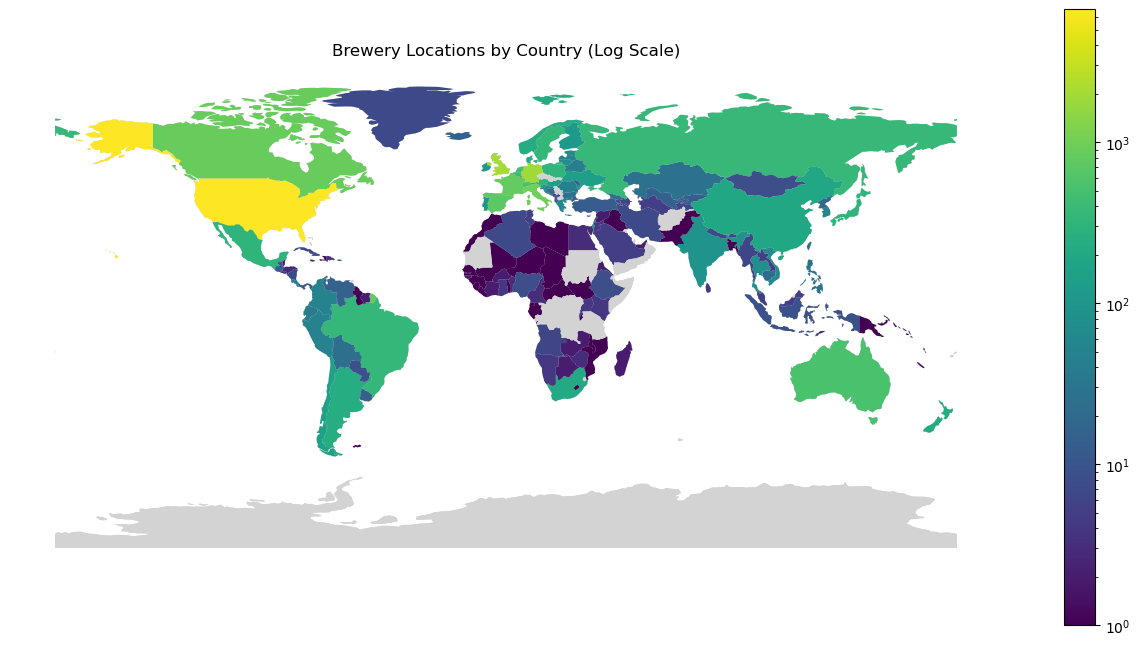

In [18]:
# Do some renaming of country names to match the map dataset
breweries_country_counts.loc[breweries_country_counts['country'] == 'United States', 'country'] = 'United States of America'

# Plot on a map the data
world = gpd.read_file("https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip").rename(columns={'ADMIN': 'name'})
merged = world.merge(breweries_country_counts, how='left', left_on='name', right_on='country')

# Create figure
fig, ax = plt.subplots(figsize=(16, 8))
world.plot(ax=ax, color='lightgray')  

# Plot with log scale normalization
merged.plot(
    column='count',
    ax=ax,
    legend=True,
    cmap='viridis',  
    norm=mcolors.LogNorm(vmin=1, vmax=merged['count'].max()), 
    missing_kwds={"color": "lightgray"}
)
ax.set_title('Brewery Locations by Country (Log Scale)')
plt.axis('off')
plt.show()

### BeerAdvocate

#### Loading the fixed data

In [19]:
df_beers = pl.read_parquet("./data/BeerAdvocate/processed/beers.pq")
df_breweries = pl.read_parquet("./data/BeerAdvocate/processed/breweries.pq")
df_users = pl.read_parquet("./data/BeerAdvocate/processed/users.pq")
df_ratings_no_text = pl.read_parquet("./data/BeerAdvocate/processed/ratings_no_text.pq")

### Data distribution

Now we can take a look at what our data looks like visually. Taking a look at data can often reveal hidden patterns or distributions that are not easily visible while just looking at the numbers.

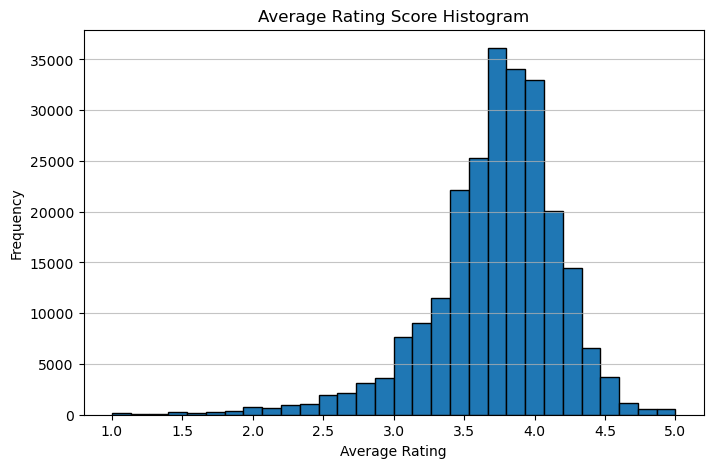

In [20]:
# Convert the 'rating_score_avg' column to a list for plotting
rating_score_avg = df_beers.select(pl.col("rating_score_avg").filter(pl.col("rating_score_avg").is_not_null())).to_series().to_list()

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(rating_score_avg, bins=30, edgecolor='black')
plt.title('Average Rating Score Histogram')
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

The average score is normally distributed. Most of the beers get a score in the high threes or the low fours. 

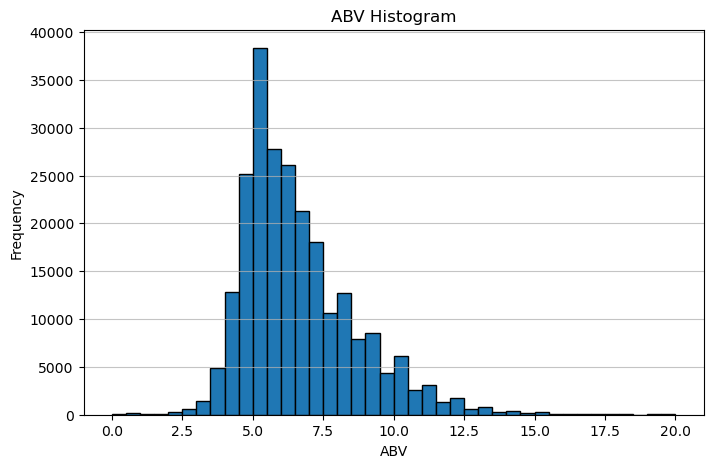

In [21]:
# Sample data selection
abv = df_beers.select(pl.col("abv").filter(pl.col("abv").is_not_null())).to_series().to_list()

# Plot histogram with more bins between 0 and 10
plt.figure(figsize=(8, 5))
plt.hist(abv, bins=40, range=(0, 20), edgecolor='black')  # Increase number of bins for better resolution
plt.title('ABV Histogram')
plt.xlabel('ABV')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()


The ABV on the other hand, seems at first sight to follow a right-skewed distribution. There are very few beers with less than 4% alcohol.

The following three plots are for the number of beers per brewery, the number of reviews per beer and the number of reviews per user. All three of them show a lot of entries in the beginning, and a few entries with very large numbers. This seems to suggest a power law. We can investigate this.

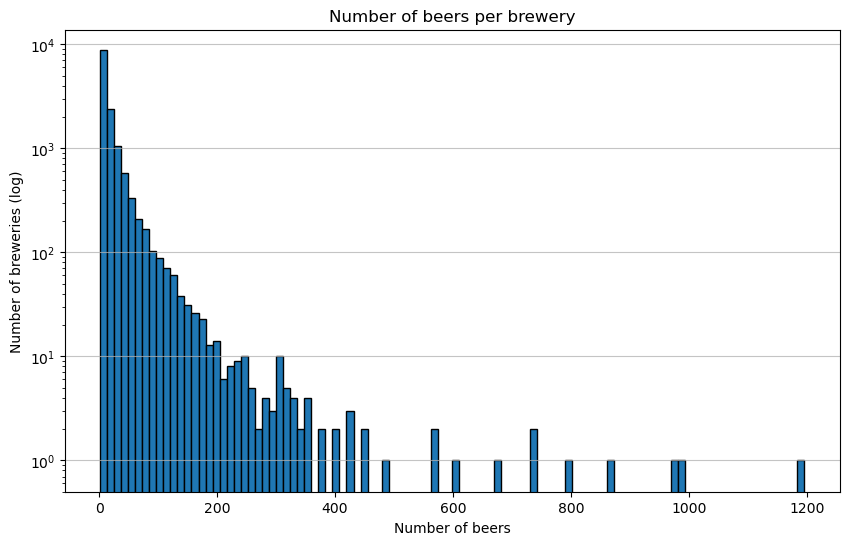

In [22]:
# Plot an histogram with the number of beers per brewery
values = df_breweries['beers_count'].value_counts()

# Display the plot
fig, ax = plt.subplots(figsize=(10, 6))
plt.hist(values["beers_count"], bins=100, weights=values["count"], edgecolor='black')
plt.yscale('log')
plt.xlabel('Number of beers')
plt.ylabel('Number of breweries (log)')
plt.title('Number of beers per brewery')
plt.grid(axis='y', alpha=0.75)
plt.ylim(bottom=0.5)
plt.show()

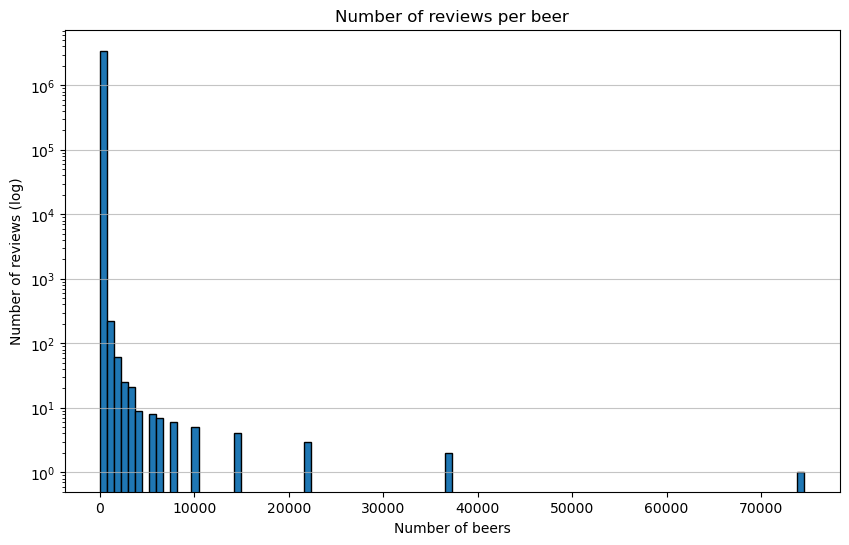

In [23]:
# Plot an histogram with the number of reviews for each beer
values = df_beers['nbr_ratings'].value_counts()

# Display the plot
fig, ax = plt.subplots(figsize=(10, 6))
# plt.hist(values["nbr_ratings"], bins=100, weights=values["count"], edgecolor='black')
plt.hist(values["count"], bins=100, weights=values["nbr_ratings"], edgecolor='black')
plt.yscale('log')
plt.ylabel('Number of reviews (log)')
plt.xlabel('Number of beers')
plt.title('Number of reviews per beer')
plt.grid(axis='y', alpha=0.75)
plt.ylim(bottom=0.5)
plt.show()

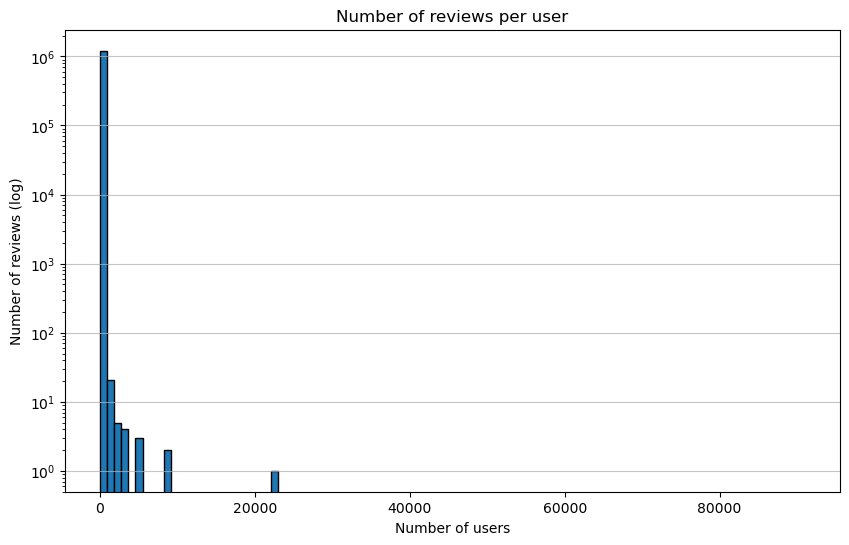

In [24]:
# Plot an histogram with the number of reviews for each user
values = df_users['nbr_ratings'].value_counts()

# Display the plot
fig, ax = plt.subplots(figsize=(10, 6))
# plt.hist(values["nbr_ratings"], bins=100, weights=values["count"], edgecolor='black')
plt.hist(values["count"], bins=100, weights=values["nbr_ratings"], edgecolor='black')
plt.yscale('log')
plt.ylabel('Number of reviews (log)')
plt.xlabel('Number of users')
plt.title('Number of reviews per user')
plt.grid(axis='y', alpha=0.75)
plt.ylim(bottom=0.5)
plt.show()

To verify if we are actually dealing with power laws, we can plot the plots again, but now as a probability density function on a log-log scale.

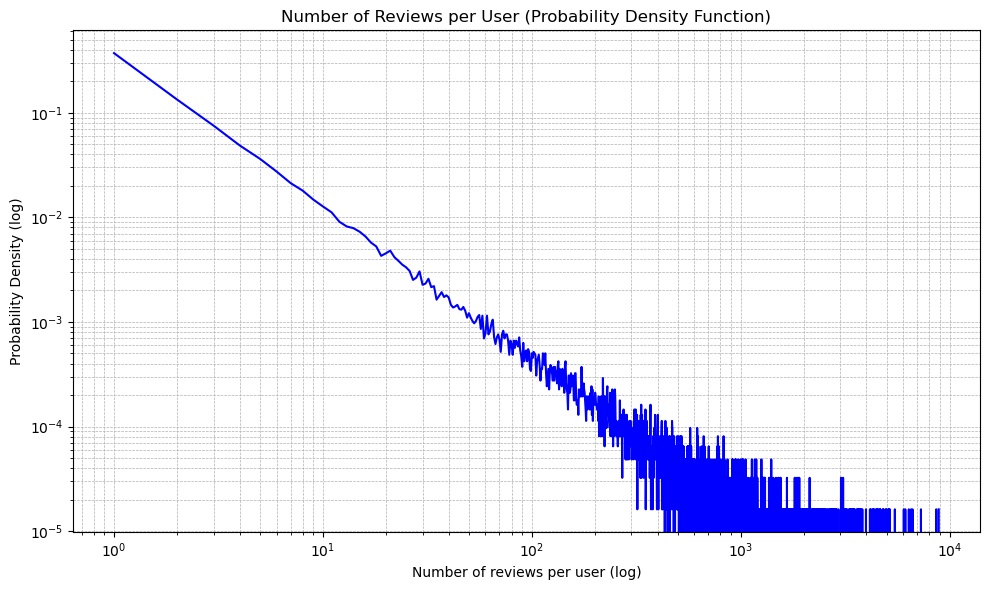

In [25]:
values = df_users['nbr_ratings'].value_counts().to_pandas()

all_ratings = np.arange(values['nbr_ratings'].min(), values['nbr_ratings'].max() + 1)
values = values.set_index('nbr_ratings').reindex(all_ratings)
values = values.fillna(0)  # Fill missing counts with 0

# Calculate PDF as normalized counts
pdf = values['count'] / values['count'].sum()

# Plotting the PDF
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(values.index, pdf, color='blue')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Number of reviews per user (log)')
ax.set_ylabel('Probability Density (log)')
ax.set_title('Number of Reviews per User (Probability Density Function)')
ax.grid(True, which="both", ls="--", linewidth=0.5)

plt.tight_layout()
plt.show()

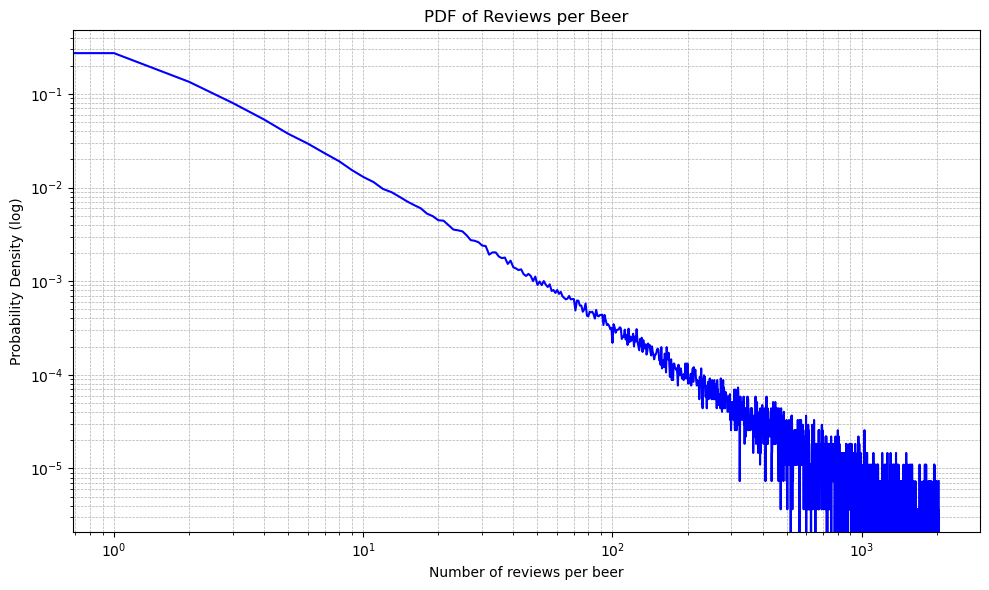

In [26]:
values = df_beers['nbr_ratings'].value_counts().to_pandas()

all_ratings = np.arange(values.index.min(), values.index.max() + 1)
values = values.set_index('nbr_ratings').reindex(all_ratings)
values = values.fillna(0)  # Fill missing counts with 0

# Calculate PDF as normalized counts
pdf = values['count'] / values['count'].sum()

# Plotting the PDF
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(values.index, pdf, color='blue')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Number of reviews per beer')
ax.set_ylabel('Probability Density (log)')
ax.set_title('PDF of Reviews per Beer')
ax.grid(True, which="both", ls="--", linewidth=0.5)

plt.tight_layout()
plt.show()

In these two cases, we indeed see that both plots are close to a straight line, with a lot of noise in the bottom-right corner. This is usual, as we have very few data points here and thus expect a lot of noise. In both cases, we are indeed dealing with a power law. This has some consequences, statistics like the mean, standard deviation, and variance are meaningless and should be avoided. Other metrics like the median should be used instead.

We can see if this holds for our number of beers per brewery as well.

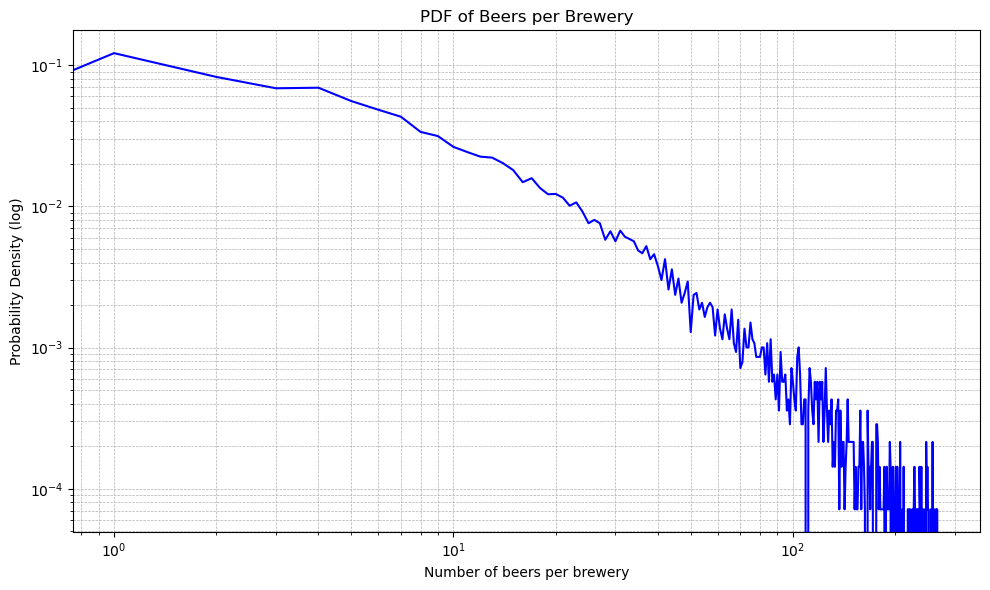

In [27]:
values = df_breweries['beers_count'].value_counts().to_pandas()

all_ratings = np.arange(values.index.min(), values.index.max() + 1)
values = values.set_index('beers_count').reindex(all_ratings)
values = values.fillna(0)  # Fill missing counts with 0

# Calculate PDF as normalized counts
pdf = values['count'] / values['count'].sum()

# Plotting the PDF
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(values.index, pdf, color='blue')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Number of beers per brewery')
ax.set_ylabel('Probability Density (log)')
ax.set_title('PDF of Beers per Brewery')
ax.grid(True, which="both", ls="--", linewidth=0.5)

plt.tight_layout()
plt.show()

This line is not a straight line. In this case we are therefore not dealing with a power law.

We can now do some initial exploration into potential correlations in our dataframe.

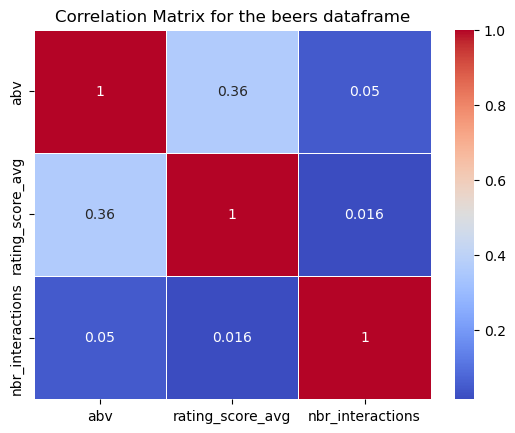

In [28]:
correlation_matrix = df_beers_corr.to_pandas().dropna().corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix for the beers dataframe')
plt.show()

The correlation between ABV and the average rating is 0.3. This is a relatively weak but definitely noticable correlation. This is likely because users of the platform are experienced drinkers and prefer heavier beers. 

### Geographical analysis

##### User locations by country

As can be seen in the graph below, the largest continent in terms of user base is by far the North America.

Europe comes in second, and South America, Asia and Australia also have sizable audiences. 

Africa and Antarctica both have very few users. The Middle-East is also very devoid of any users. This makes sense, as many countries here have laws that ban the production and consumption of alcohol. 

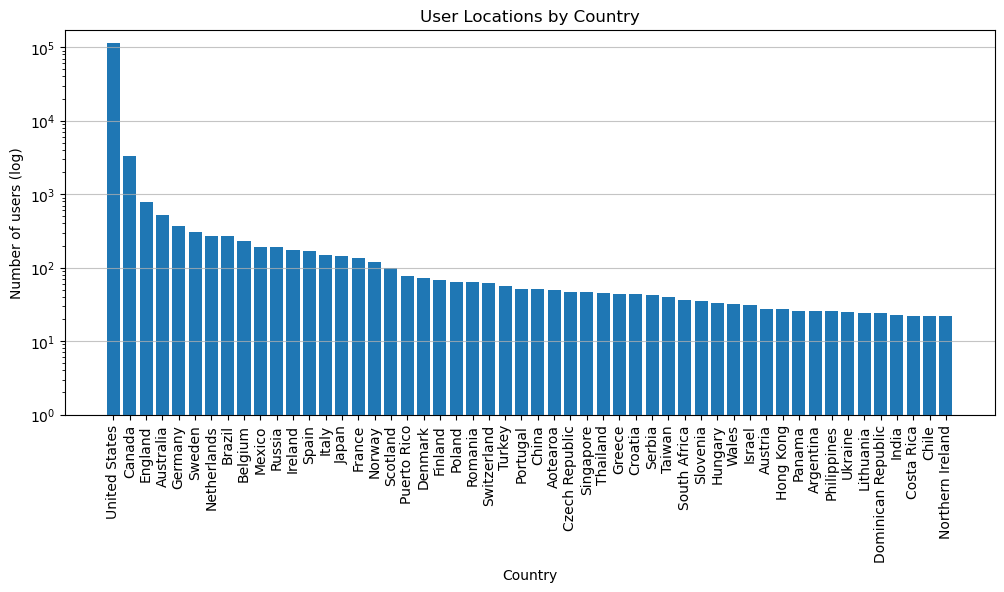

In [29]:
# Convert the polaris datastructure into a pandas dataframe
df_users_pd = df_users.to_pandas()

# Extract country names (split by ', ' and take the last part)
df_users_pd['country'] = df_users_pd['location'].dropna().apply(lambda x: x.split(', ')[0])

# Count occurrences of each country and filter out countries with less than 20 occurrences
country_counts = df_users_pd['country'].value_counts().reset_index()
country_counts_filtered = country_counts[country_counts['count'] >= 20]

# Plot the countries
plt.figure(figsize=(12, 5))
plt.bar(country_counts_filtered['country'], country_counts_filtered['count'])
plt.xticks(rotation=90)
plt.xlabel('Country')
plt.ylabel('Number of users (log)')
plt.yscale('log')
plt.title('User Locations by Country')
plt.grid(axis='y', alpha=0.75)
plt.ylim(bottom=1)
plt.show()

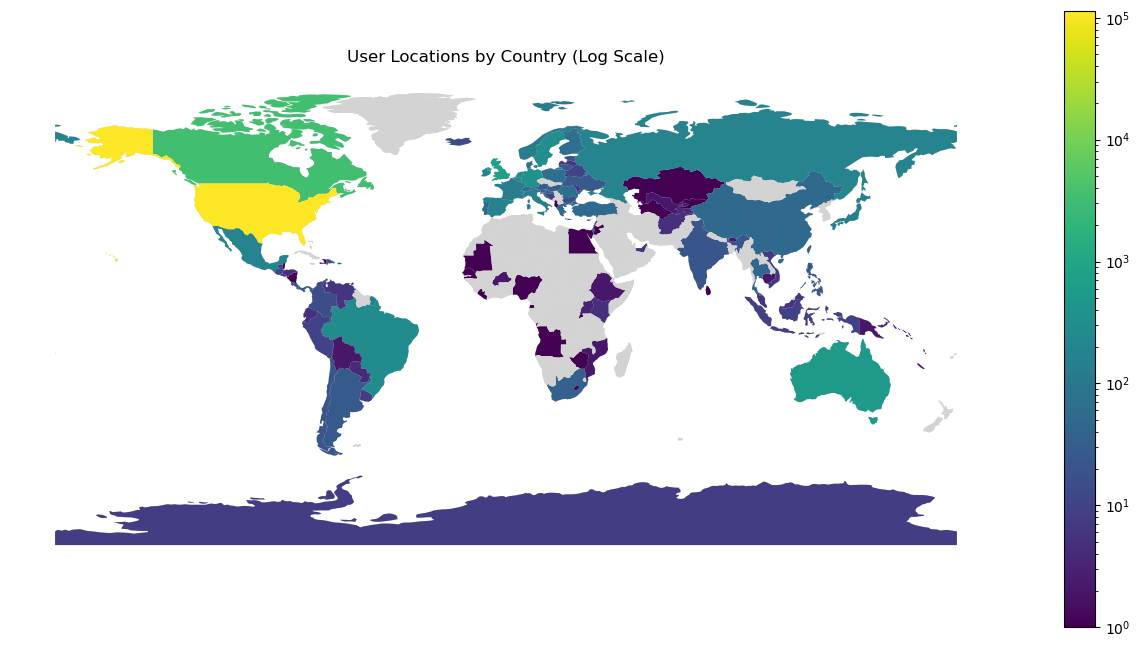

In [30]:
# Do some renaming of country names to match the map dataset
country_counts.loc[country_counts['country'] == 'United States', 'country'] = 'United States of America'
country_counts.loc[country_counts['country'] == 'England', 'country'] = 'United Kingdom'

# Plot on a map the data
world = gpd.read_file("https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip").rename(columns={'ADMIN': 'name'})
merged = world.merge(country_counts, how='left', left_on='name', right_on='country')

# Create figure
fig, ax = plt.subplots(figsize=(16, 8))
world.plot(ax=ax, color='lightgray')  

# Plot with log scale normalization
merged.plot(
    column='count',
    ax=ax,
    legend=True,
    cmap='viridis',  
    norm=mcolors.LogNorm(vmin=1, vmax=merged['count'].max()), 
    missing_kwds={"color": "lightgray"}
)
ax.set_title('User Locations by Country (Log Scale)')
plt.axis('off')
plt.show()

##### Brewery locations by country

In the following two graphs we can see geographical location of breweries. This seems to be quite similar to the location of the users, but a bit flatter. This is likely because users will upload beers they have tried while traveling, and there is a ceiling to how many breweries you can enter into the database, as there are only so many breweries in a given country. 

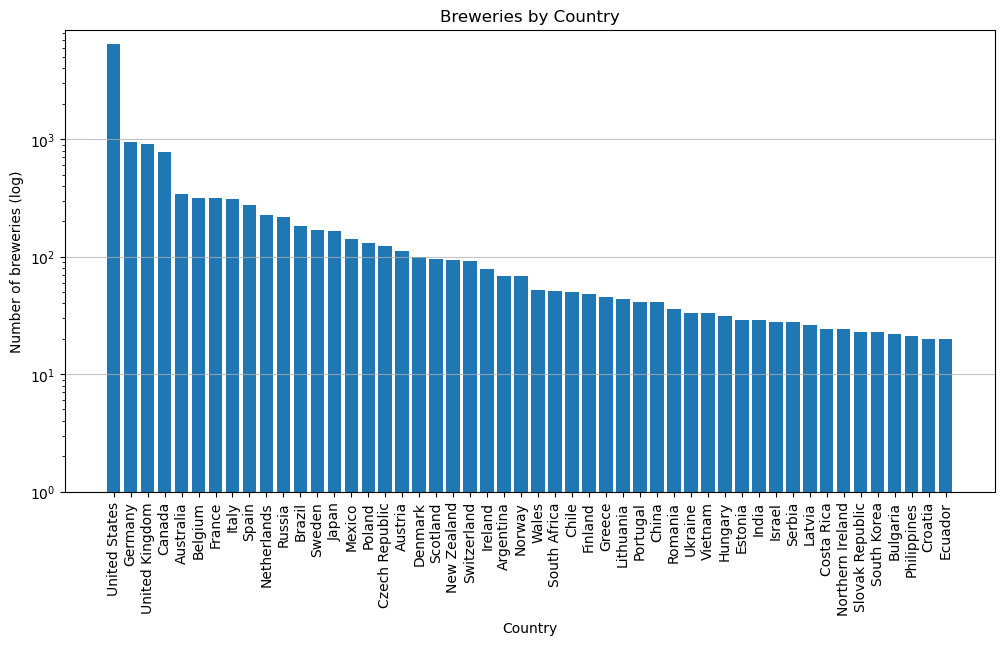

In [31]:
# Convert the polaris datastructure into a pandas dataframe
df_breweries_pd = df_breweries.to_pandas()
df_breweries_pd.loc[df_breweries_pd['location'] == 'England', 'location'] = 'United Kingdom'

# Extract country names (split by ', ' and take the last part)
df_breweries_pd['country'] = df_breweries_pd['location'].dropna().apply(lambda x: x.split(', ')[0])

# Count occurrences of each country and filter out countries with less than 20 occurrences
breweries_country_counts = df_breweries_pd['country'].value_counts().reset_index()
breweries_counts_filtered = breweries_country_counts[breweries_country_counts['count'] >= 20]

# Plot the countries
plt.figure(figsize=(12, 6))
plt.bar(breweries_counts_filtered['country'], breweries_counts_filtered['count'])
plt.xticks(rotation=90)
plt.xlabel('Country')
plt.yscale('log')
plt.ylabel('Number of breweries (log)')
plt.title('Breweries by Country')
plt.grid(axis='y', alpha=0.75)
plt.ylim(bottom=1)
plt.show()

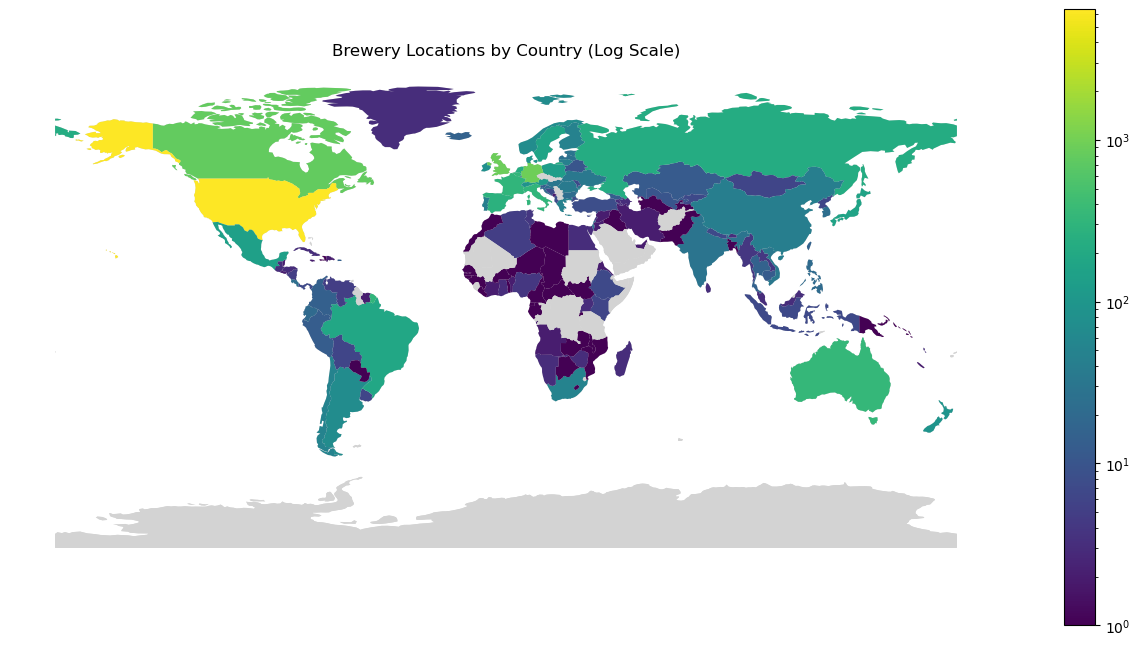

In [32]:
# Do some renaming of country names to match the map dataset
breweries_country_counts.loc[breweries_country_counts['country'] == 'United States', 'country'] = 'United States of America'

# Plot on a map the data
world = gpd.read_file("https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip").rename(columns={'ADMIN': 'name'})
merged = world.merge(breweries_country_counts, how='left', left_on='name', right_on='country')

# Create figure
fig, ax = plt.subplots(figsize=(16, 8))
world.plot(ax=ax, color='lightgray')  

# Plot with log scale normalization
merged.plot(
    column='count',
    ax=ax,
    legend=True,
    cmap='viridis',  
    norm=mcolors.LogNorm(vmin=1, vmax=merged['count'].max()), 
    missing_kwds={"color": "lightgray"}
)
ax.set_title('Brewery Locations by Country (Log Scale)')
plt.axis('off')
plt.show()

##### Discussion
Given that we have both the information regarding the brewery location and the users location we can link each review with the location of the beer and the origin country of users. 

### Temporal analysis

In this plot we investigate when users joined the website. It is clear to see that the site experiences its peak in 2014. We can also see that our data covers up to the year 2017. 

##### Users join date distribution

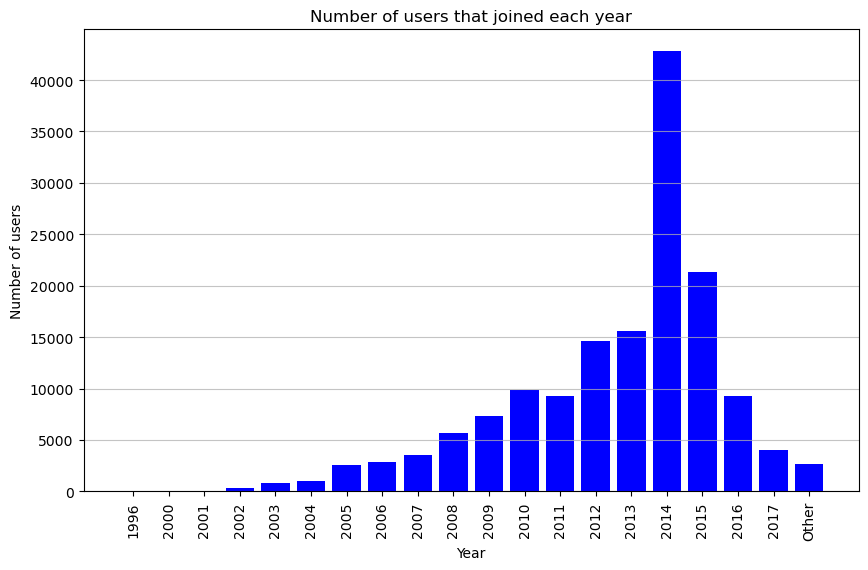

In [33]:
# Plot the number of users that joined each year
values = df_users_pd[df_users_pd['joined'].notna()]['joined'].dt.year.value_counts()

# Convert the index to string
values.index = values.index.astype(str)
values['Other'] = df_users_pd['joined'].isna().sum()

# Sort the values
values = values.sort_index()

# Display the plot
fig, ax = plt.subplots(figsize=(10, 6))
plt.bar(values.index, values.values, color='blue')
plt.xlabel('Year')
plt.xticks(values.index, rotation=90)
plt.ylabel('Number of users')
plt.title('Number of users that joined each year')
plt.grid(axis='y', alpha=0.75)
plt.show()

### MatchedBeers

##### Loading the fixed data

In [37]:
path = "./data/MatchedBeer/"
file_paths = [path + "beers.csv", path + "breweries.csv", path + "ratings.csv", path + "users.csv"]
dataframes_list = load_and_process_files(file_paths)

df_beers = dataframes_list[0]
df_breweries = dataframes_list[1]
df_ratings = dataframes_list[2]
df_users = dataframes_list[3]

#### Data distribuition
Now we can take a look at what our data looks like visually. Taking a look at data can often reveal hidden patterns or distributions that are not easily visible while just looking at the numbers.

In [38]:
def plot_column_presence(df, title="BA vs RB Column Presence"):
    # Identify ba and rb columns
    ba_columns = [col for col in df.columns if col.endswith('_ba')]
    rb_columns = [col for col in df.columns if col.endswith('_rb')]

    # Create lists of base metric names without _ba or _rb suffixes
    ba_metrics = [col.replace('_ba', '') for col in ba_columns]
    rb_metrics = [col.replace('_rb', '') for col in rb_columns]
    
    # Create a unique set of all metrics present in either ba or rb
    all_metrics = sorted(set(ba_metrics) | set(rb_metrics))

    # Prepare data for plotting presence as binary (1 = present, 0 = absent)
    ba_presence = [1 if metric in ba_metrics else 0 for metric in all_metrics]
    rb_presence = [1 if metric in rb_metrics else 0 for metric in all_metrics]

    # Plotting
    fig, ax = plt.subplots(figsize=(12, len(all_metrics) * 0.4))
    bar_width = 0.4
    index = range(len(all_metrics))
    
    # BA columns presence
    ax.barh(index, ba_presence, height=bar_width, label="BA", color="skyblue", align='center')
    
    # RB columns presence, offset horizontally for easy comparison
    ax.barh([i + bar_width for i in index], rb_presence, height=bar_width, label="RB", color="salmon", align='center')
    
    # Set labels and title
    ax.set_yticks([i + bar_width / 2 for i in index])
    ax.set_yticklabels(all_metrics)
    ax.set_xlabel("Presence (1 = Present, 0 = Absent)")
    ax.set_title(title)
    ax.legend()
    
    plt.tight_layout()
    plt.show()

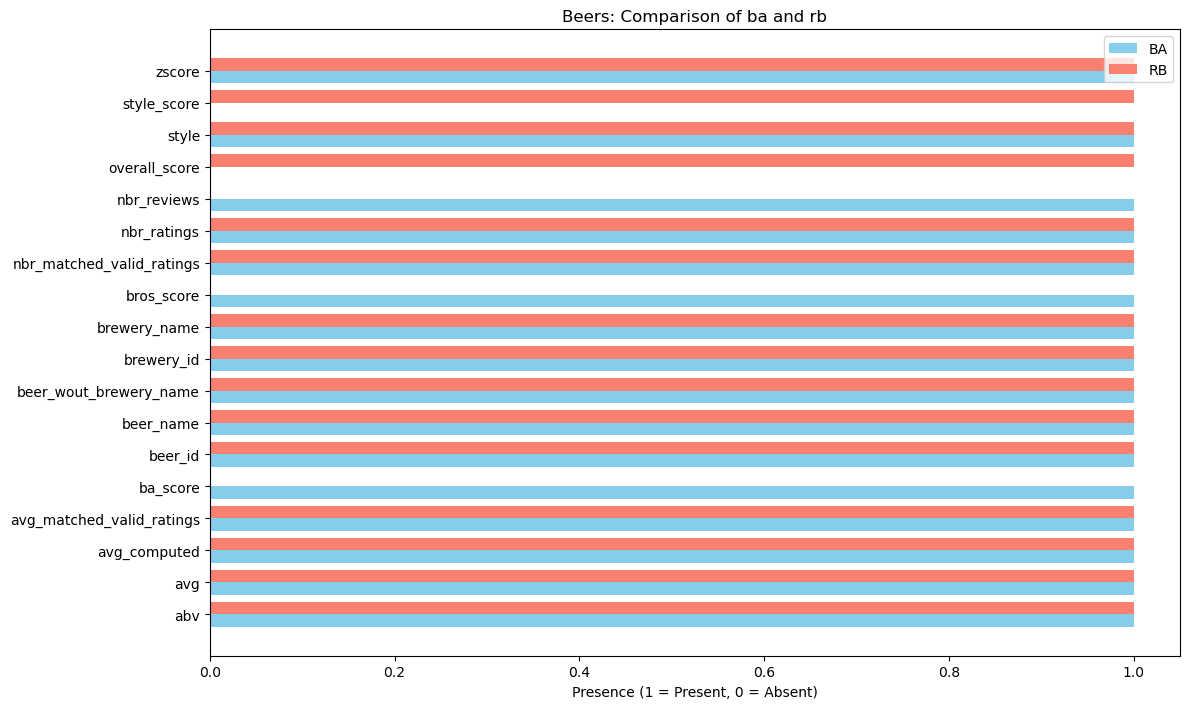

In [39]:
plot_column_presence(df_beers, title="Beers: Comparison of ba and rb")

Here we visually show the Beer columns that exist for each platform. As can be seen `nbr_reviews`, `ba_score`, `bros_score`, and `ba_score` exist only for Beer Advocate. the columns `style_score` and `overall_score` exist only for Rate Beer.

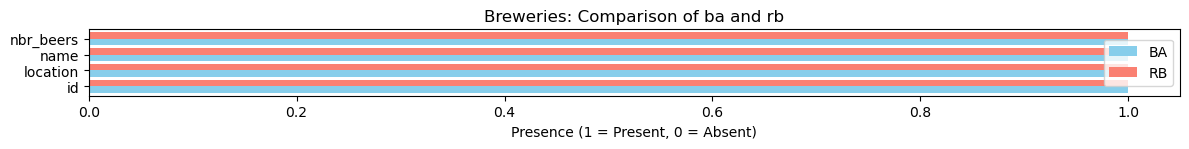

In [40]:
plot_column_presence(df_breweries, title="Breweries: Comparison of ba and rb")

As can be seen, all Brewery columns exist for both platforms.

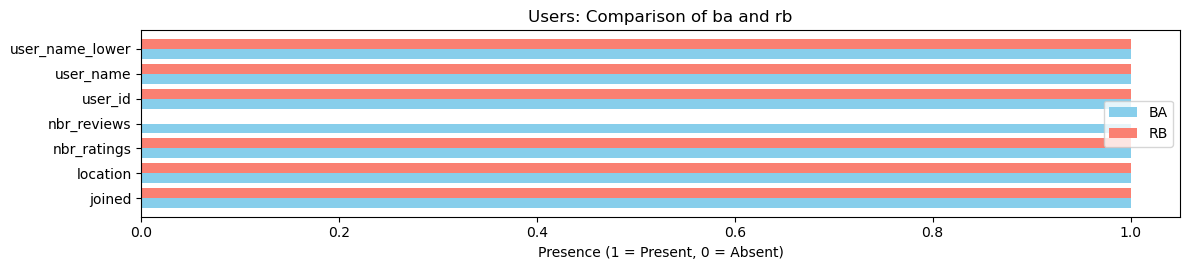

In [41]:
plot_column_presence(df_users, title="Users: Comparison of ba and rb")

Here we see that Rate Beer does not have a `nbr_reviews` column

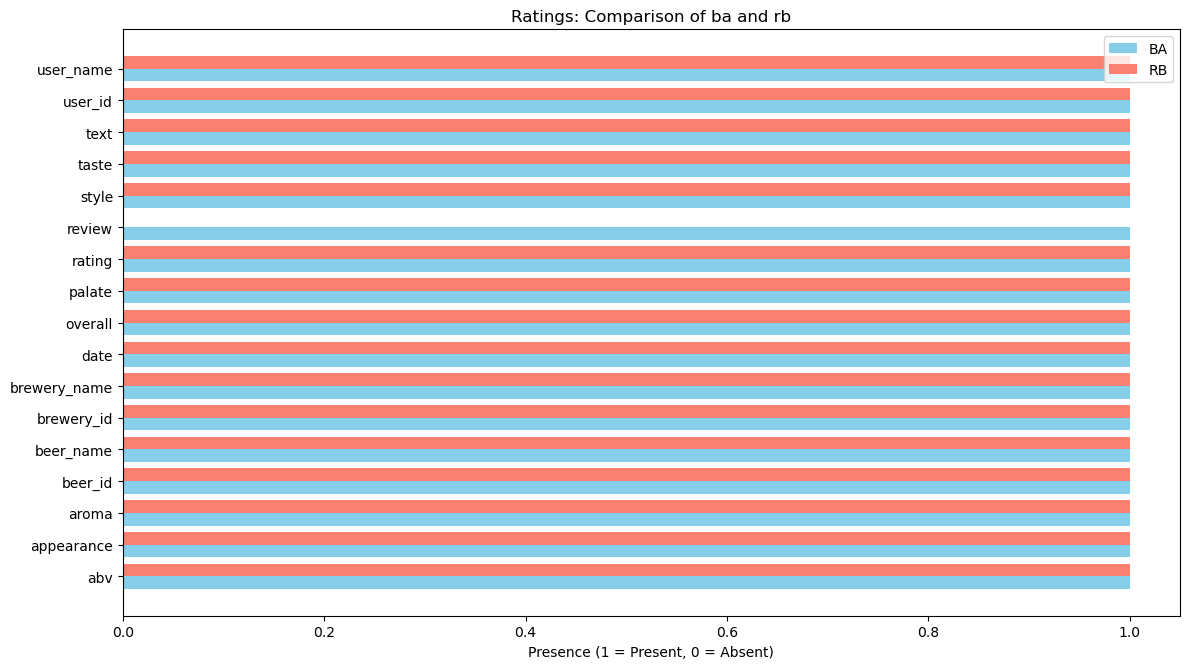

In [42]:
plot_column_presence(df_ratings, title="Ratings: Comparison of ba and rb")

Here we can see that in the Ratings dataset, only Beer Advocate has a `review` column.

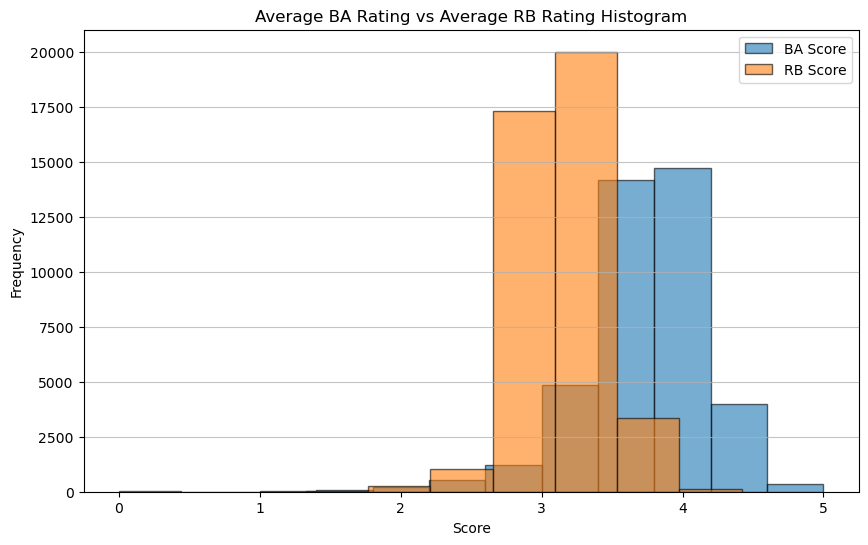

In [43]:
# Extract ba and rb scores as lists, filtering out null values
ba_score = df_beers.select(pl.col("avg_ba").filter(pl.col("avg_ba").is_not_null())).to_series().to_list()
rb_score = df_beers.select(pl.col("avg_rb").filter(pl.col("avg_rb").is_not_null())).to_series().to_list()

# Plot histograms
plt.figure(figsize=(10, 6))
plt.hist(ba_score, bins=10, edgecolor='black', alpha=0.6, label='BA Score')
plt.hist(rb_score, bins=10, edgecolor='black', alpha=0.6, label='RB Score')
plt.title('Average BA Rating vs Average RB Rating Histogram')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.show()

Overall Distribution: The BA scores tend to be higher on average than the RB scores. This aligns with previous insights suggesting that BeerAdvocate users generally rate beers more favorably.

Tail Differences: BeerAdvocate has more ratings in the upper range (4 to 5), while RateBeer has very few ratings in that range, reflecting a more conservative or stricter scoring trend on RateBeer.

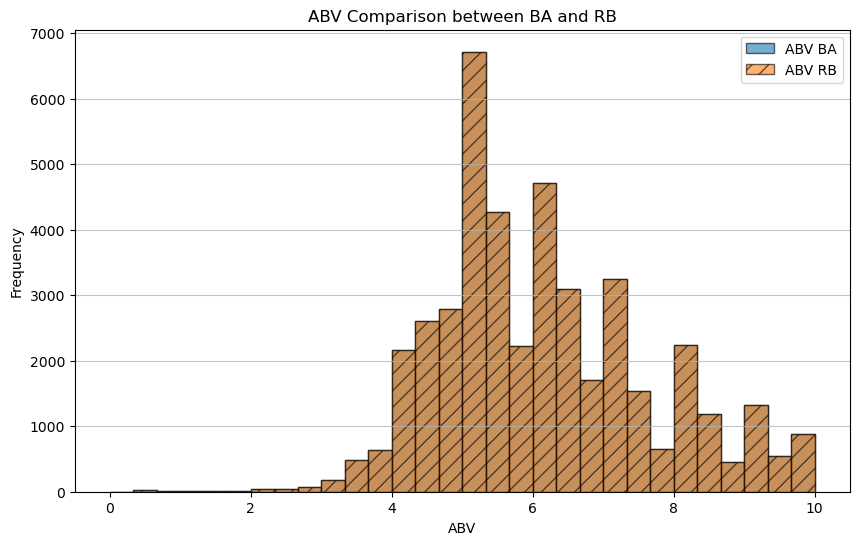

In [44]:
# Extract abv values for ba and rb, filtering out null values
abv_ba = df_beers.select(pl.col("abv_ba").filter(pl.col("abv_ba").is_not_null())).to_series().to_list()
abv_rb = df_beers.select(pl.col("abv_rb").filter(pl.col("abv_rb").is_not_null())).to_series().to_list()

# Plot overlapping histograms for ABV with hatching pattern on ABV RB
plt.figure(figsize=(10, 6))

# Plot ABV BA with solid fill
plt.hist(abv_ba, bins=30, range=(0, 10), edgecolor='black', alpha=0.6, label='ABV BA')

# Plot ABV RB with hatching pattern
plt.hist(abv_rb, bins=30, range=(0, 10), edgecolor='black', alpha=0.6, label='ABV RB', hatch='//')

plt.title('ABV Comparison between BA and RB')
plt.xlabel('ABV')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.show()

As expected, the ABV volmue is identical for the two websites. Analysis of this is seen in the notebooks for the individual platforms. 


The following three plots are for the number of beers per brewery, the number of reviews per beer and the number of reviews per user. All three of them show a lot of entries in the beginning, and a few entries with very large numbers. This seems to suggest a power law. We can investigate this.

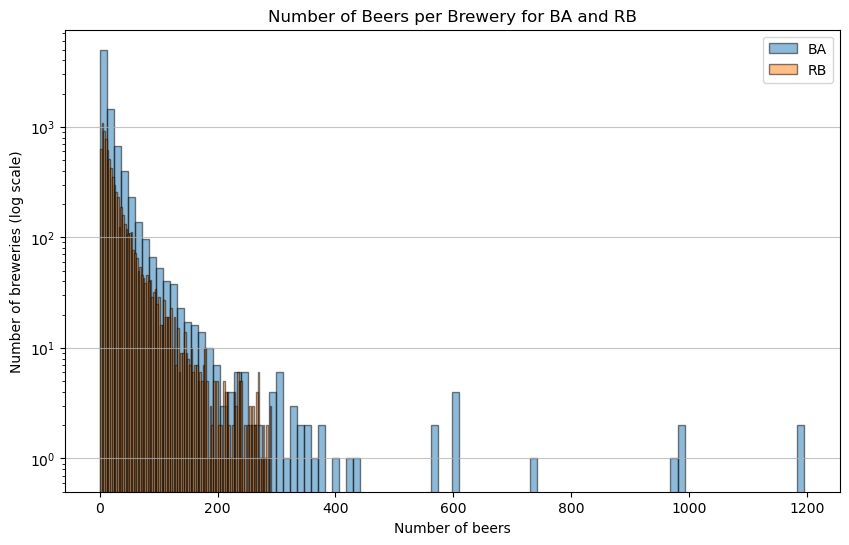

In [45]:
import matplotlib.pyplot as plt

# Extract the number of beers per brewery for BA and RB, filtering out null values
nbr_beers_ba = df_breweries.select(pl.col("nbr_beers_ba").filter(pl.col("nbr_beers_ba").is_not_null())).to_series().to_list()
nbr_beers_rb = df_breweries.select(pl.col("nbr_beers_rb").filter(pl.col("nbr_beers_rb").is_not_null())).to_series().to_list()

# Plot overlapping histograms for BA and RB
fig, ax = plt.subplots(figsize=(10, 6))

# Plot for BA with some transparency
plt.hist(nbr_beers_ba, bins=100, edgecolor='black', alpha=0.5, label='BA', log=True)

# Plot for RB with some transparency
plt.hist(nbr_beers_rb, bins=100, edgecolor='black', alpha=0.5, label='RB', log=True)

# Adding labels and title
plt.xlabel('Number of beers')
plt.ylabel('Number of breweries (log scale)')
plt.title('Number of Beers per Brewery for BA and RB')
plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.ylim(bottom=0.5)
plt.show()


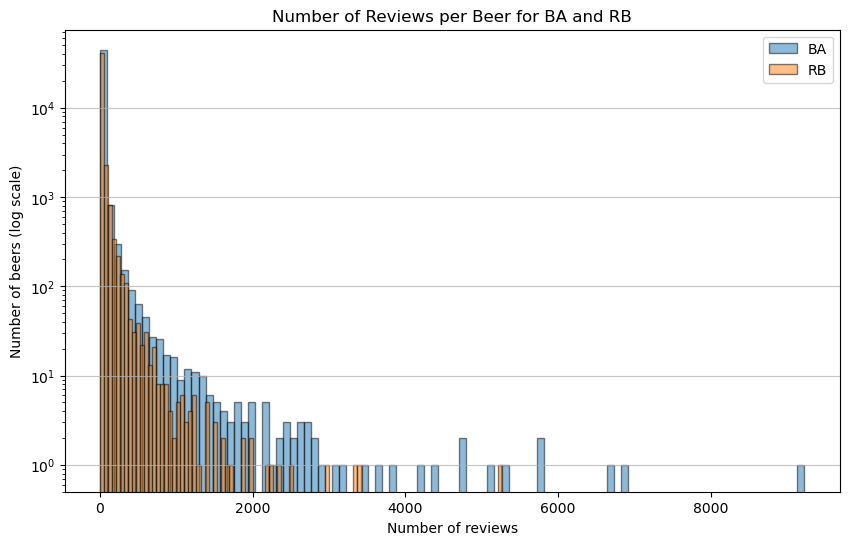

In [46]:
# Extract the number of ratings for BA and RB, filtering out null values
nbr_ratings_ba = df_beers.select(pl.col("nbr_ratings_ba").filter(pl.col("nbr_ratings_ba").is_not_null())).to_series().to_list()
nbr_ratings_rb = df_beers.select(pl.col("nbr_ratings_rb").filter(pl.col("nbr_ratings_rb").is_not_null())).to_series().to_list()

# Plot overlapping histograms for BA and RB
fig, ax = plt.subplots(figsize=(10, 6))

# Plot for BA with some transparency
plt.hist(nbr_ratings_ba, bins=100, edgecolor='black', alpha=0.5, label='BA', log=True)

# Plot for RB with some transparency
plt.hist(nbr_ratings_rb, bins=100, edgecolor='black', alpha=0.5, label='RB', log=True)

# Adding labels and title
plt.xlabel('Number of reviews')
plt.ylabel('Number of beers (log scale)')
plt.title('Number of Reviews per Beer for BA and RB')
plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.ylim(bottom=0.5)
plt.show()

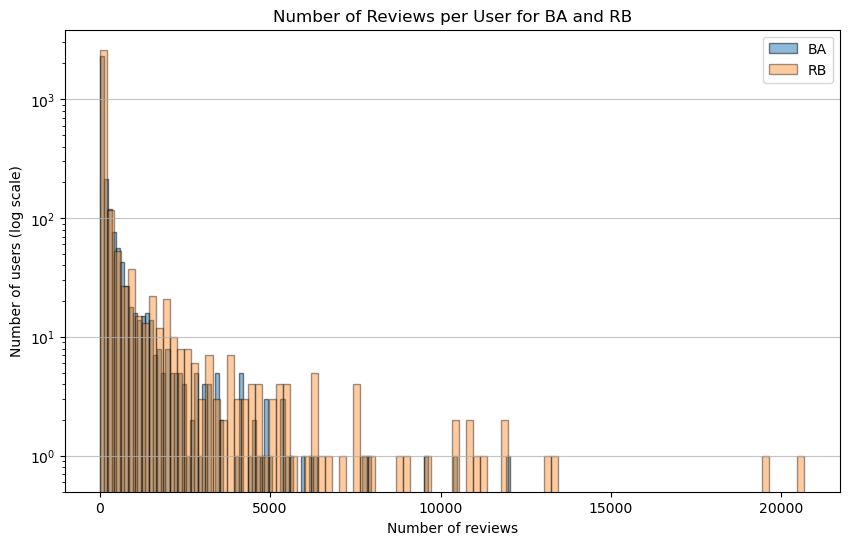

In [47]:
# Extract the number of ratings per user for BA and RB, filtering out null values
nbr_ratings_ba = df_users.select(pl.col("nbr_ratings_ba").filter(pl.col("nbr_ratings_ba").is_not_null())).to_series().to_list()
nbr_ratings_rb = df_users.select(pl.col("nbr_ratings_rb").filter(pl.col("nbr_ratings_rb").is_not_null())).to_series().to_list()

# Plot overlapping histograms for BA and RB
fig, ax = plt.subplots(figsize=(10, 6))

# Plot for BA with some transparency
plt.hist(nbr_ratings_ba, bins=100, edgecolor='black', alpha=0.5, label='BA', log=True)

# Plot for RB with some transparency
plt.hist(nbr_ratings_rb, bins=100, edgecolor='black', alpha=0.4, label='RB', log=True)

# Adding labels and title
plt.xlabel('Number of reviews')
plt.ylabel('Number of users (log scale)')
plt.title('Number of Reviews per User for BA and RB')
plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.ylim(bottom=0.5)
plt.show()

More detail is given earlier for the individual platforms regarding verifying if we are dealing with power laws. In these diagrams we see that the two platforms seem to show a similar trend, so we will take the same approach as earlier and plot as a probability density function on a log-log scale.

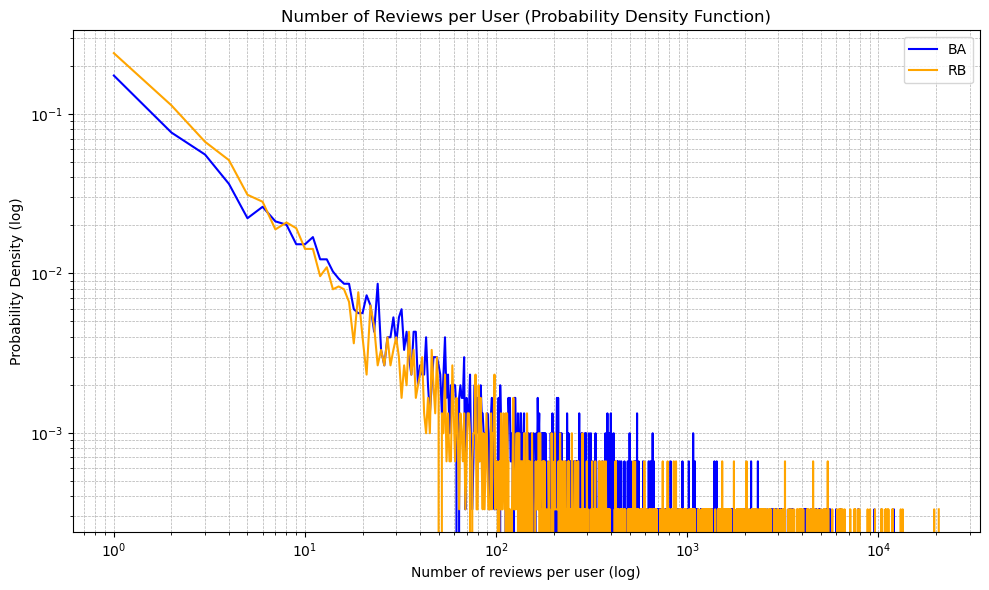

In [48]:
# Count occurrences for 'nbr_ratings_ba' and 'nbr_ratings_rb'
values_ba = df_users.select(pl.col("nbr_ratings_ba")).to_series().value_counts().to_pandas()
values_ba.columns = ['nbr_ratings', 'count_ba']

values_rb = df_users.select(pl.col("nbr_ratings_rb")).to_series().value_counts().to_pandas()
values_rb.columns = ['nbr_ratings', 'count_rb']

# Create a complete range of ratings, filling missing counts with 0
all_ratings = np.arange(min(values_ba['nbr_ratings'].min(), values_rb['nbr_ratings'].min()), 
                        max(values_ba['nbr_ratings'].max(), values_rb['nbr_ratings'].max()) + 1)

# Reindex and fill missing values with 0 for both BA and RB
values_ba = values_ba.set_index('nbr_ratings').reindex(all_ratings, fill_value=0).reset_index()
values_ba.columns = ['nbr_ratings', 'count_ba']

values_rb = values_rb.set_index('nbr_ratings').reindex(all_ratings, fill_value=0).reset_index()
values_rb.columns = ['nbr_ratings', 'count_rb']

# Calculate PDFs as normalized counts
pdf_ba = values_ba['count_ba'] / values_ba['count_ba'].sum()
pdf_rb = values_rb['count_rb'] / values_rb['count_rb'].sum()

# Plotting the PDFs for both BA and RB
fig, ax = plt.subplots(figsize=(10, 6))

# Plot PDF for BA
ax.plot(values_ba['nbr_ratings'], pdf_ba, color='blue', label='BA')

# Plot PDF for RB
ax.plot(values_rb['nbr_ratings'], pdf_rb, color='orange', label='RB')

# Set log scales and labels
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Number of reviews per user (log)')
ax.set_ylabel('Probability Density (log)')
ax.set_title('Number of Reviews per User (Probability Density Function)')
ax.legend()
ax.grid(True, which="both", ls="--", linewidth=0.5)

plt.tight_layout()
plt.show()

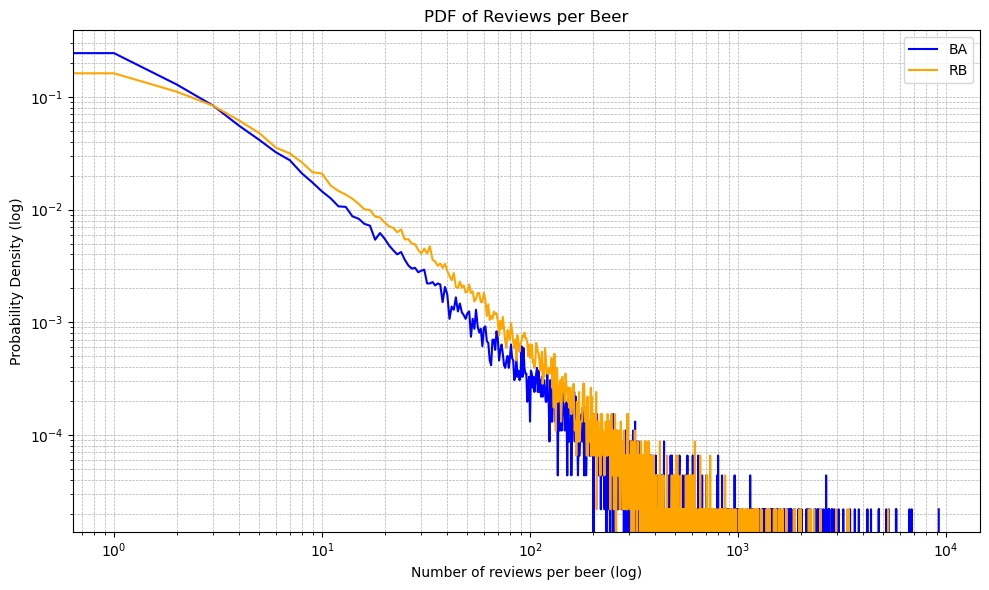

In [49]:
# Count occurrences for 'nbr_ratings_ba' and 'nbr_ratings_rb'
values_ba = df_beers.select(pl.col("nbr_ratings_ba")).to_series().value_counts().to_pandas()
values_ba.columns = ['nbr_ratings', 'count_ba']

values_rb = df_beers.select(pl.col("nbr_ratings_rb")).to_series().value_counts().to_pandas()
values_rb.columns = ['nbr_ratings', 'count_rb']

# Define the full range of ratings from min to max across both datasets
all_ratings = np.arange(min(values_ba['nbr_ratings'].min(), values_rb['nbr_ratings'].min()), 
                        max(values_ba['nbr_ratings'].max(), values_rb['nbr_ratings'].max()) + 1)

# Reindex to fill any missing ratings with 0
values_ba = values_ba.set_index('nbr_ratings').reindex(all_ratings, fill_value=0).reset_index()
values_ba.columns = ['nbr_ratings', 'count_ba']

values_rb = values_rb.set_index('nbr_ratings').reindex(all_ratings, fill_value=0).reset_index()
values_rb.columns = ['nbr_ratings', 'count_rb']

# Calculate PDFs as normalized counts
pdf_ba = values_ba['count_ba'] / values_ba['count_ba'].sum()
pdf_rb = values_rb['count_rb'] / values_rb['count_rb'].sum()

# Plotting the PDFs for both BA and RB
fig, ax = plt.subplots(figsize=(10, 6))

# Plot PDF for BA
ax.plot(values_ba['nbr_ratings'], pdf_ba, color='blue', label='BA')

# Plot PDF for RB
ax.plot(values_rb['nbr_ratings'], pdf_rb, color='orange', label='RB')

# Set log scales and labels
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Number of reviews per beer (log)')
ax.set_ylabel('Probability Density (log)')
ax.set_title('PDF of Reviews per Beer')
ax.legend()
ax.grid(True, which="both", ls="--", linewidth=0.5)

plt.tight_layout()
plt.show()

In these two diagrams, we indeed see that both plots are close to a straight line, for both platforms, with a lot of noise in the bottom-right corner. This is usual, as we have very few data points here and thus expect a lot of noise. In both cases, we are indeed dealing with a power law. This has some consequences, statistics like the mean, standard deviation, and variance are meaningless and should be avoided. Other metrics like the median should be used instead.

We can see if this holds for our number of beers per brewery for each platform as well.

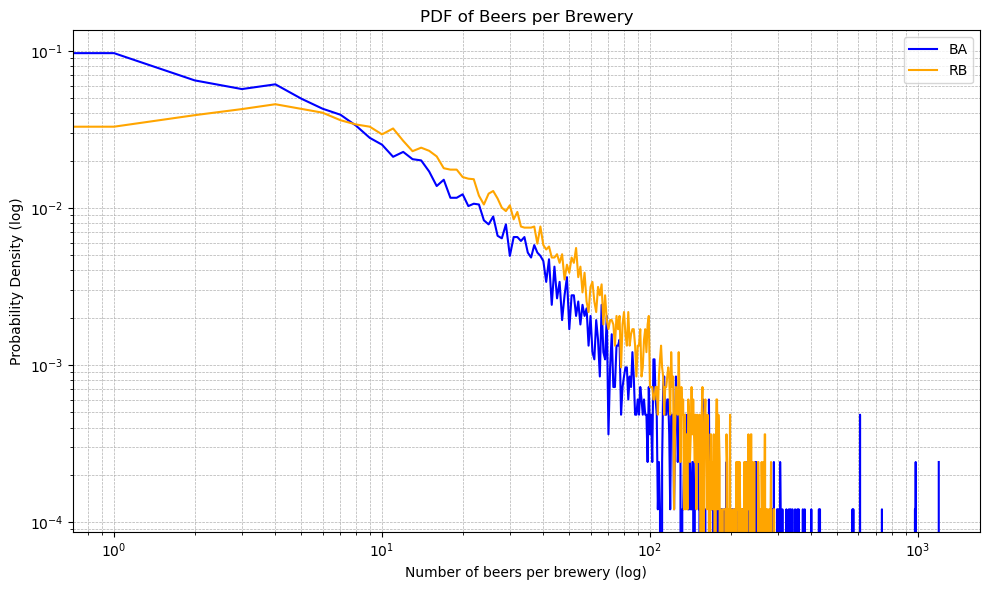

In [50]:
# Count occurrences for 'beers_count_ba' and 'beers_count_rb'
values_ba = df_breweries.select(pl.col("nbr_beers_ba")).to_series().value_counts().to_pandas()
values_ba.columns = ['nbr_beers', 'count_ba']

values_rb = df_breweries.select(pl.col("nbr_beers_rb")).to_series().value_counts().to_pandas()
values_rb.columns = ['nbr_beers', 'count_rb']

# Define the full range of beers count from min to max across both datasets
all_counts = np.arange(min(values_ba['nbr_beers'].min(), values_rb['nbr_beers'].min()), 
                       max(values_ba['nbr_beers'].max(), values_rb['nbr_beers'].max()) + 1)

# Reindex to fill any missing beers counts with 0
values_ba = values_ba.set_index('nbr_beers').reindex(all_counts, fill_value=0).reset_index()
values_ba.columns = ['nbr_beers', 'count_ba']

values_rb = values_rb.set_index('nbr_beers').reindex(all_counts, fill_value=0).reset_index()
values_rb.columns = ['nbr_beers', 'count_rb']

# Calculate PDFs as normalized counts
pdf_ba = values_ba['count_ba'] / values_ba['count_ba'].sum()
pdf_rb = values_rb['count_rb'] / values_rb['count_rb'].sum()

# Plotting the PDFs for both BA and RB
fig, ax = plt.subplots(figsize=(10, 6))

# Plot PDF for BA
ax.plot(values_ba['nbr_beers'], pdf_ba, color='blue', label='BA')

# Plot PDF for RB
ax.plot(values_rb['nbr_beers'], pdf_rb, color='orange', label='RB')

# Set log scales and labels
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Number of beers per brewery (log)')
ax.set_ylabel('Probability Density (log)')
ax.set_title('PDF of Beers per Brewery')
ax.legend()
ax.grid(True, which="both", ls="--", linewidth=0.5)

plt.tight_layout()
plt.show()

These lines are not straight. In this case, we are therefore not dealing with a power law.

In [51]:
# Select the relevant columns for correlation analysis from both BA and RB
df_beers_corr = df_beers.select([
    pl.col("nbr_ratings_ba"), 
    pl.col("nbr_reviews_ba"),
    pl.col("abv_ba"),
    pl.col("avg_ba"),
    pl.col("avg_computed_ba"),
    pl.col("bros_score_ba"),
    pl.col("ba_score_ba"),
    pl.col("zscore_ba"),
    
    pl.col("nbr_ratings_rb"),
    pl.col("abv_rb"),
    pl.col("avg_rb"),
    pl.col("avg_computed_rb"),
    pl.col("overall_score_rb"),
    pl.col("zscore_rb")
])

correlation_matrix = df_beers_corr.to_pandas().dropna().corr().corr()

In [52]:
correlation_matrix

,nbr_ratings_ba,nbr_reviews_ba,abv_ba,avg_ba,avg_computed_ba,bros_score_ba,ba_score_ba,zscore_ba,nbr_ratings_rb,abv_rb,avg_rb,avg_computed_rb,overall_score_rb,zscore_rb
nbr_ratings_ba,1.000000,0.991844,-0.658721,-0.688321,-0.691696,-0.621117,-0.630960,-0.684198,0.978864,-0.658721,-0.640500,-0.674024,-0.705139,-0.655774
nbr_reviews_ba,0.991844,1.000000,-0.628789,-0.746595,-0.749446,-0.649823,-0.696967,-0.740676,0.995469,-0.628789,-0.692034,-0.723619,-0.747714,-0.703912
abv_ba,-0.658721,-0.628789,1.000000,0.174085,0.190323,-0.127623,0.158016,0.186455,-0.607881,1.000000,0.332568,0.360416,0.416177,0.358474
avg_ba,-0.688321,-0.746595,0.174085,1.000000,0.999014,0.698775,0.990742,0.997634,-0.778089,0.174085,0.893746,0.899259,0.871352,0.885453
avg_computed_ba,-0.691696,-0.749446,0.190323,0.999014,1.000000,0.685575,0.989575,0.999262,-0.780517,0.190323,0.901872,0.907422,0.880189,0.894563
bros_score_ba,-0.621117,-0.649823,-0.127623,0.698775,0.685575,1.000000,0.642482,0.680602,-0.662590,-0.127623,0.377401,0.397208,0.370499,0.368115
ba_score_ba,-0.630960,-0.696967,0.158016,0.990742,0.989575,0.642482,1.000000,0.988433,-0.734089,0.158016,0.904217,0.905143,0.875741,0.893162
zscore_ba,-0.684198,-0.740676,0.186455,0.997634,0.999262,0.680602,0.988433,1.000000,-0.771516,0.186455,0.899759,0.904849,0.877503,0.893126
nbr_ratings_rb,0.978864,0.995469,-0.607881,-0.778089,-0.780517,-0.662590,-0.734089,-0.771516,1.000000,-0.607881,-0.719854,-0.750269,-0.769134,-0.730135
abv_rb,-0.658721,-0.628789,1.000000,0.174085,0.190323,-0.127623,0.158016,0.186455,-0.607881,1.000000,0.332568,0.360416,0.416177,0.358474


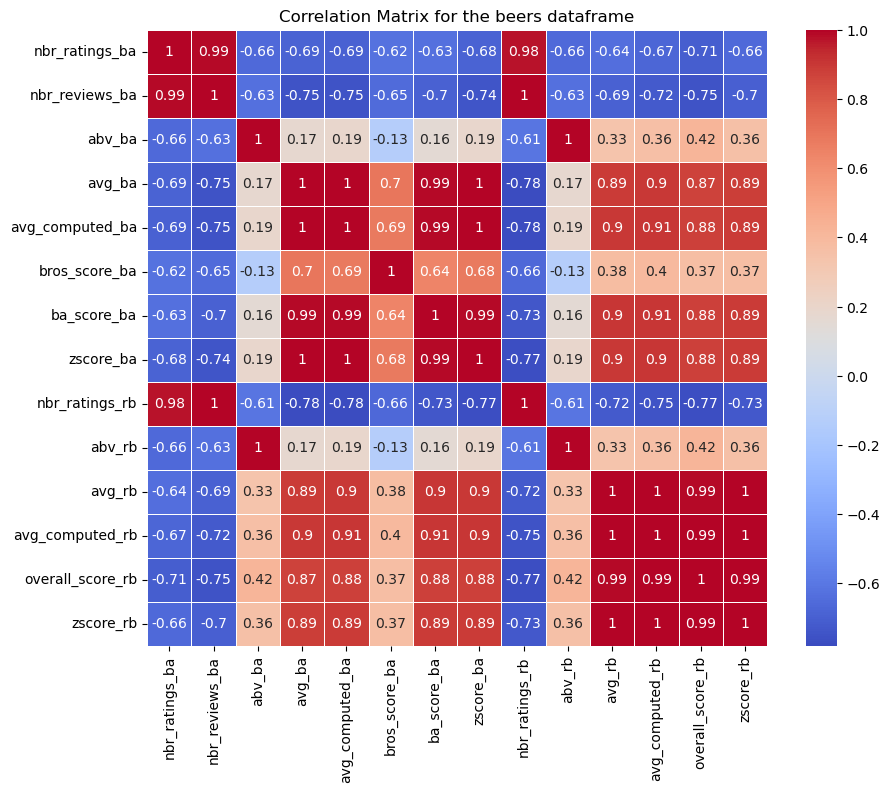

In [53]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix for the beers dataframe')
plt.show()

1. Cross-Platform Rating and Review Counts:
   - There is a very high correlation between `nbr_ratings_ba` and `nbr_ratings_rb` (0.95). This indicates that beers with a large number of ratings on one platform are likely to be popular on the other platform as well, suggesting that popularity trends are consistent across both BeerAdvocate and RateBeer.
   - Similarly, `nbr_reviews_ba` and `nbr_ratings_rb` show a high correlation of 0.95. This reinforces the idea that the same beers attract user attention on both platforms.

2. Average Scores and Computed Averages:
   - The `avg_ba` and `avg_rb` scores have a high correlation (0.89), as do `avg_computed_ba` and `avg_computed_rb` (0.91). This shows that users on both platforms tend to have similar opinions on the quality of beers, even if the rating scales and review systems may differ slightly. The high alignment of computed averages (`avg_computed`) indicates that these values are consistent across platforms.
   - Additionally, `zscore_ba` and `zscore_rb` show a strong correlation of 0.89, suggesting that the standardized scores across both platforms are aligned, providing further evidence of similar user preferences.

3. Cross-Platform Perceived Quality:
   - `ba_score_ba` and `overall_score_rb` have a strong correlation (0.89), which implies that the overall perceived quality of beers is quite similar between the two platforms. Despite potentially different rating mechanisms, users on BeerAdvocate and RateBeer generally reach the same consensus about a beer’s quality.
   - `bros_score_ba` also has moderate correlations with RateBeer scores (e.g., `overall_score_rb` at 0.68). This implies that the opinions of BeerAdvocate's "Bros" subset are somewhat aligned with general user opinions on RateBeer, but there are still notable differences, as seen from the slightly lower correlation.

4. Alcohol By Volume (ABV):
   - The correlation between `abv_ba` and `avg_rb` (0.33) and between `abv_rb` and `avg_ba` (0.33) suggests a moderate relationship between a beer’s ABV and its average score across platforms. This could imply that higher ABV beers tend to be rated favorably by users on both platforms, aligning with the general trend of experienced drinkers preferring stronger beers. Though we do have the keep in mind that this is still a very weak correlation.
   - The correlation between `abv_ba` and `abv_rb` is high (0.99), which makes sense since the ABV is a fixed attribute of a beer and should be consistent across platforms.

5. Differences in Rating and Scoring Mechanisms:
   - Although the correlation between ratings and scores is high across platforms, some nuances are apparent. For instance, `ba_score_ba` and `overall_score_rb` correlate highly but are not perfectly aligned, suggesting subtle differences in how users rate beers on each platform.
   - Moreover, `bros_score_ba` has lower correlations with RateBeer scores compared to other BeerAdvocate scores, indicating that the "Bros" group on BeerAdvocate might have slightly more distinct preferences that are less aligned with RateBeer users.


#### Geographical analysis

##### User locations by country
As can be seen in the graphs below, the largest continent in terms of user base is by far the North America.

Europe comes in second, and South America, Asia and Australia also have sizable audiences.

Africa and Antarctica both have very few users. The Middle-East is also very devoid of any users. This makes sense, as many countries here have laws that ban the production and consumption of alcohol.

The difference with the matched data though opposed to the individual datasets, is that the users have been matched between the platforms - this means the countries counts for each dataset are overlapping (as seen in the first of the two diagrams below) and even more importantly, that we have lost a lot of data (seen by the lack of countries colored, and the more "purple" coloring).

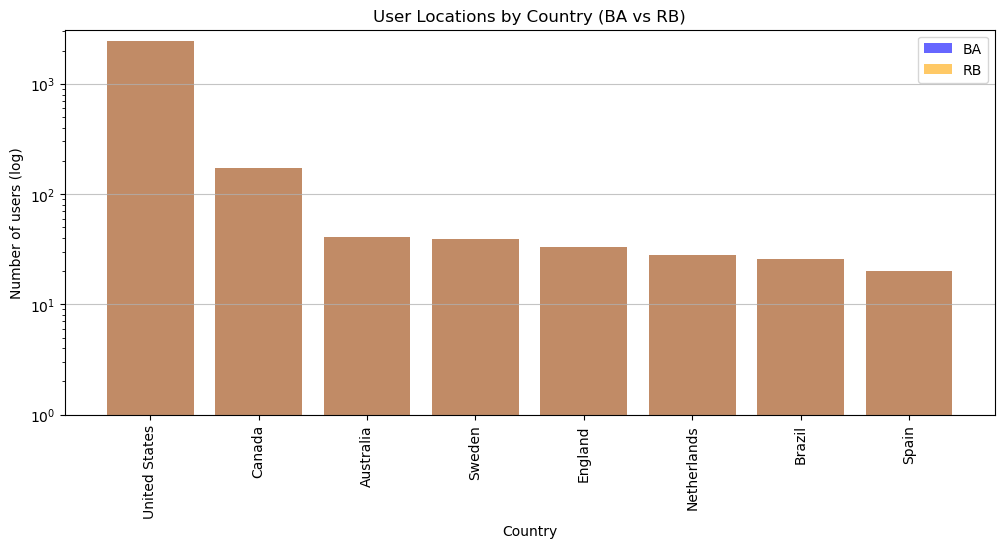

In [54]:
df_users_pd = df_users.to_pandas()

# Extract country names for BA and RB (split by ', ' and take the last part)
df_users_pd['country_ba'] = df_users_pd['location_ba'].dropna().apply(lambda x: x.split(', ')[0])
df_users_pd['country_rb'] = df_users_pd['location_rb'].dropna().apply(lambda x: x.split(', ')[0])

# Count occurrences of each country for BA and RB and rename columns for clarity
country_counts_ba = df_users_pd['country_ba'].value_counts().reset_index()
country_counts_ba.columns = ['country', 'count_ba']

country_counts_rb = df_users_pd['country_rb'].value_counts().reset_index()
country_counts_rb.columns = ['country', 'count_rb']

# Filter out countries with fewer than 20 occurrences for both BA and RB
country_counts_ba_filtered = country_counts_ba[country_counts_ba['count_ba'] >= 20]
country_counts_rb_filtered = country_counts_rb[country_counts_rb['count_rb'] >= 20]

# Plot the countries for BA and RB with overlapping bars
plt.figure(figsize=(12, 5))
plt.bar(country_counts_ba_filtered['country'], country_counts_ba_filtered['count_ba'], color='blue', alpha=0.6, label='BA')
plt.bar(country_counts_rb_filtered['country'], country_counts_rb_filtered['count_rb'], color='orange', alpha=0.6, label='RB')
plt.xticks(rotation=90)
plt.xlabel('Country')
plt.ylabel('Number of users (log)')
plt.yscale('log')
plt.title('User Locations by Country (BA vs RB)')
plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.ylim(bottom=1)
plt.show()

KeyError: 'count_ba'

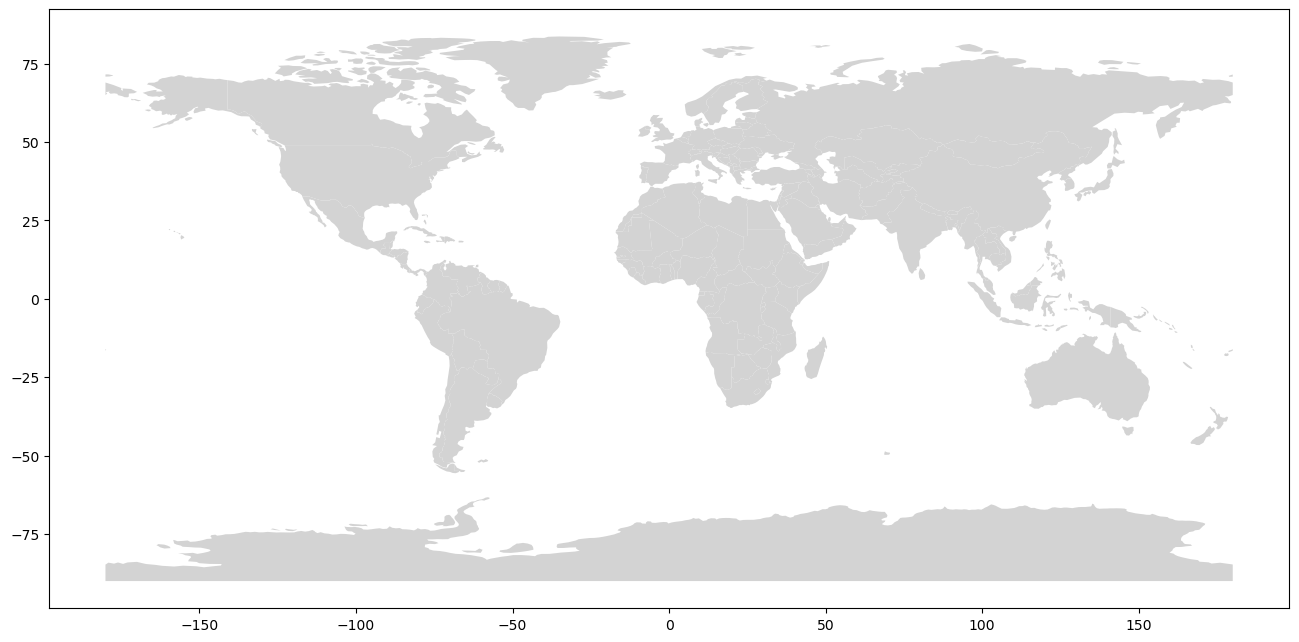

In [ ]:
# Do some renaming of country names to match the map dataset
country_counts.loc[country_counts['country'] == 'United States', 'country'] = 'United States of America'
country_counts.loc[country_counts['country'] == 'England', 'country'] = 'United Kingdom'

# Plot on a map the data
world = gpd.read_file("https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip").rename(columns={'ADMIN': 'name'})
merged = world.merge(country_counts, how='left', left_on='name', right_on='country')

# Create figure
fig, ax = plt.subplots(figsize=(16, 8))
world.plot(ax=ax, color='lightgray')  

# Plot with log scale normalization
merged.plot(
    column='count_ba',
    ax=ax,
    legend=True,
    cmap='viridis',  
    norm=mcolors.LogNorm(vmin=1, vmax=merged['count_ba'].max()), 
    missing_kwds={"color": "lightgray"}
)
ax.set_title('User Locations by Country (Log Scale)')
plt.show()

##### Brewery locations by country

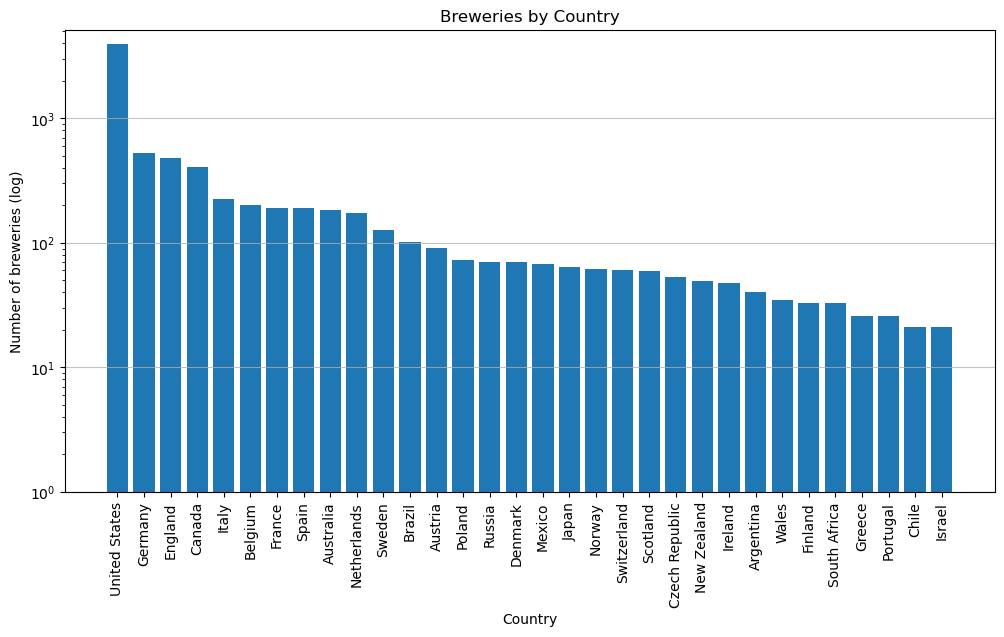

In [57]:
# Convert the polaris datastructure into a pandas dataframe
df_breweries_pd = df_breweries.to_pandas()
df_breweries_pd.loc[df_breweries_pd['location_ba'] == 'England', 'location'] = 'United Kingdom'

# Extract country names (split by ', ' and take the last part)
df_breweries_pd['country'] = df_breweries_pd['location_ba'].dropna().apply(lambda x: x.split(', ')[0])

# Count occurrences of each country and filter out countries with less than 20 occurrences
breweries_country_counts = df_breweries_pd['country'].value_counts().reset_index()
breweries_counts_filtered = breweries_country_counts[breweries_country_counts['count'] >= 20]

# Plot the countries
plt.figure(figsize=(12, 6))
plt.bar(breweries_counts_filtered['country'], breweries_counts_filtered['count'])
plt.xticks(rotation=90)
plt.xlabel('Country')
plt.yscale('log')
plt.ylabel('Number of breweries (log)')
plt.title('Breweries by Country')
plt.grid(axis='y', alpha=0.75)
plt.ylim(bottom=1)
plt.show()

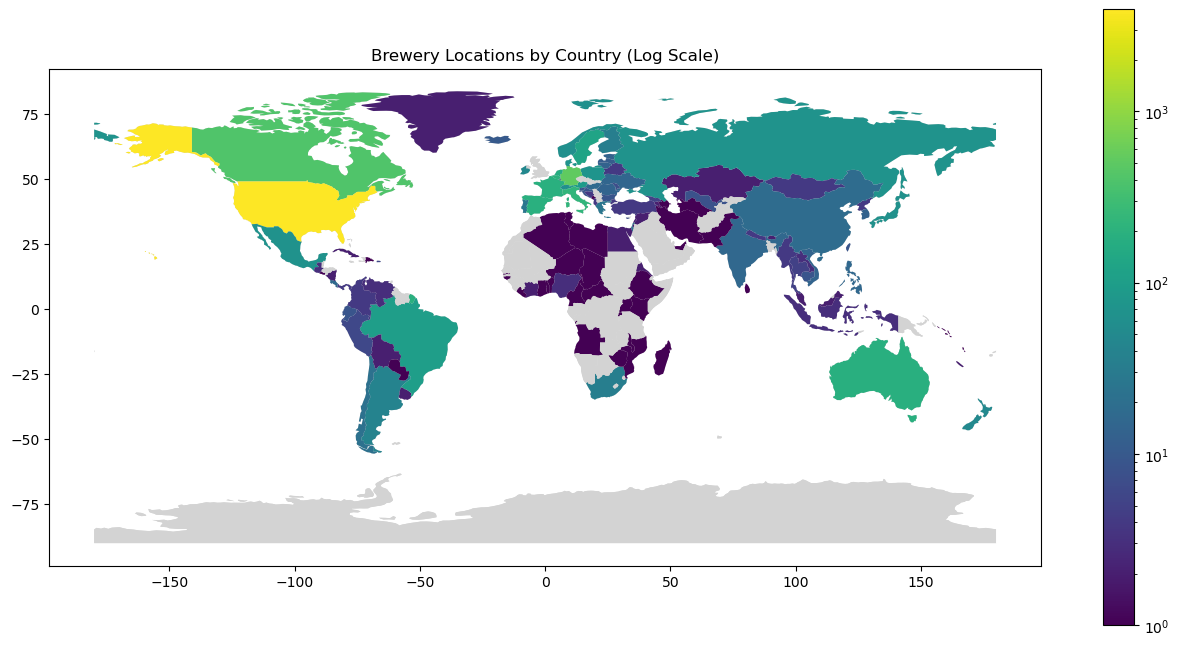

In [59]:
# Do some renaming of country names to match the map dataset
breweries_country_counts.loc[breweries_country_counts['country'] == 'United States', 'country'] = 'United States of America'

# Plot on a map the data
world = gpd.read_file("https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip").rename(columns={'ADMIN': 'name'})
merged = world.merge(breweries_country_counts, how='left', left_on='name', right_on='country')

# Create figure
fig, ax = plt.subplots(figsize=(16, 8))
world.plot(ax=ax, color='lightgray')  

# Plot with log scale normalization
merged.plot(
    column='count',
    ax=ax,
    legend=True,
    cmap='viridis',  
    norm=mcolors.LogNorm(vmin=1, vmax=merged['count'].max()), 
    missing_kwds={"color": "lightgray"}
)
ax.set_title('Brewery Locations by Country (Log Scale)')
plt.show()

This is essentially the same as the plots for the individual Beer Advocate and Rate Beer datasets but there are slightly fewer breweries due to the processing of matched data. The spread of breweries across the world is of course essentially the same.


#### Temporal analysis
In this plot we investigate when users joined the website. It is clear to see that the site experiences its peak in 2014. We can also see that our data covers up to the year 2017. 

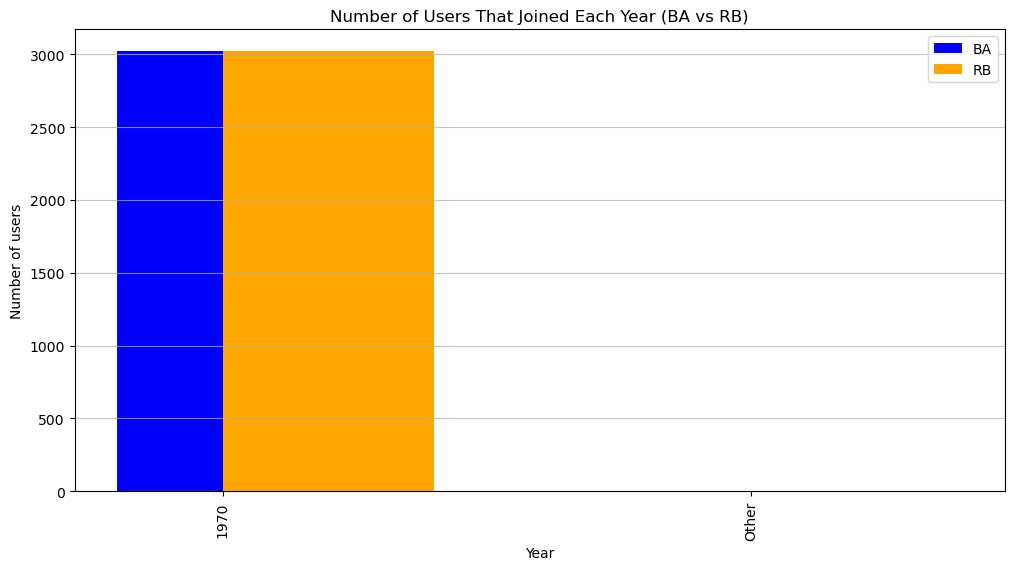

In [61]:
import pandas as pd

# Convert the Polars DataFrame to Pandas for easier manipulation
df_users_pd = df_users.to_pandas()

# Ensure that the 'joined' columns are converted to datetime (if not already)
df_users_pd['joined_ba'] = pd.to_datetime(df_users_pd['joined_ba'], errors='coerce')
df_users_pd['joined_rb'] = pd.to_datetime(df_users_pd['joined_rb'], errors='coerce')

# Extract and count join years for BA and RB, excluding NaN values
values_ba = df_users_pd[df_users_pd['joined_ba'].notna()]['joined_ba'].dt.year.value_counts().sort_index()
values_rb = df_users_pd[df_users_pd['joined_rb'].notna()]['joined_rb'].dt.year.value_counts().sort_index()

# Convert index to string for year labels
values_ba.index = values_ba.index.astype(str)
values_rb.index = values_rb.index.astype(str)

# Handle missing data by adding an "Other" category
values_ba['Other'] = df_users_pd['joined_ba'].isna().sum()
values_rb['Other'] = df_users_pd['joined_rb'].isna().sum()

# Align the indices of both series to ensure the bars line up correctly
all_years = sorted(set(values_ba.index) | set(values_rb.index))  # Combine all unique years from both datasets
values_ba = values_ba.reindex(all_years, fill_value=0)
values_rb = values_rb.reindex(all_years, fill_value=0)

# Plot the overlapping bar chart
fig, ax = plt.subplots(figsize=(12, 6))
width = 0.4  # Set bar width for overlap

# Plot BA join data
plt.bar(
    [str(year) for year in values_ba.index],  # Convert years to strings for labels
    values_ba.values,
    width=width,
    color='blue',
    label='BA',
    align='center'
)

# Plot RB join data with an offset for overlapping
plt.bar(
    [str(year) for year in values_rb.index],
    values_rb.values,
    width=width,
    color='orange',
    label='RB',
    align='edge'
)

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Number of users')
plt.xticks(rotation=90)
plt.title('Number of Users That Joined Each Year (BA vs RB)')
plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.show()

### Discussion and future work